# **PROJETO Wine-Chem**

---
**Objetivo:** Este projeto apresenta um análise de agrupamento (clustering) aplicada ao Wine Dataset, disponível publicamente no Kaggle. O objetivo é identificar padrões e similaridades entre diferentes vinhos com base em seus componentes quimícos, utilizando técnicas de aprendizado não supervisionado.

**Resumo de projeto:** Ao longo do notebook são explorados métodos de pré-processamento, redução de dimensionalidade e algortimos de clustering, com foco em avaliar como diferentes abordagens se comportam diante de um conjunto de dados real. O projeto serve tanto como demonstração  prática de habilidades em Machine Learning quanto como base para estudos de segmentação de dados e análise exploratória.

**Fonte de dados**: wine-clustering - kaggle (https://www.kaggle.com/datasets/harrywang/wine-dataset-for-clustering)

---

## **Como navegar neste notebook**
1. **Introdução & resumo do dataset** -> visão geral e dicionário de variáveis.
2. **EDA** -> Distribuição, outliers, testes de normalidade
3. **Pré-processamento** ->
4. **Modelagem** -> k-means, PCA, agrupamento hierarquico
5. **Conclusões e recomendações**

## **Dicionário de variáveis**
- Alcohol (float):
- Malic_Acid (float):
- Ash (float):
- Ash_Alcanity (float):
- Magnesium (int):
- Total_Phenols (float):
- Flavanoids (float):
- Nonflavanoid_Phenols (float):
- Proanthocyanins (float):
- Color_Intensity (float):
- Hue (float):
- OD280 (float):
- Pronline (int)

## **BIBLIOTECAS UTILIZADAS**

In [160]:
#analise e manipulação de dados
import pandas as pd
import numpy as np

#bibliotecas graficas
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import scipy.stats as sts

#pre-processamento
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
# estatistica
from statsmodels.stats.diagnostic import lilliefors
from statistics import mode
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples

#bibliotecas para verificar o agrupamento realizado pelo algortimo:
from scipy.cluster.hierarchy import dendrogram, linkage

#algortimo
from sklearn.cluster import KMeans, MeanShift
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
#!pip install kmodes
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes

## **CARREGAMENTO E RESUMO RAPIDO DO DATASET**

Nesta etapa são carregados os dados originais do Wine Dataset e realizada uma exploração inicial para verificar sua estrutura. O objetivo é compreender o formato do conjunto de dados, confirmar a presença de 13 variáveis químicas e garantir que não existam valores ausentes ou inconsistências. Esssa inspeção é essencial para orientar as próximas decisões de pré-processamento e modelagem.

In [161]:
#dataset
vinhos = pd.read_csv('../data/raw/wine-clustering.csv', sep = ',', encoding= 'utf-8')
vinhos.head(10)

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
5,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
6,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290
7,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295
8,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045
9,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


In [162]:
# CORPO DO DATASET
vinhos.shape

(178, 13)

## **EDA**
Nesta etapa foi realizado uma visualização inicial do dataset, incluindo:
- Estatística descritiva (média, desvio padrão, quartis, valores mínimo e máximo, contagem)
- Identificação dos tipos de dados (int, float, str)
- Verificação de valores ausentes e análise da moda e cada variável
  
Em seguida, conduziu-se uma análise estatístiica mais detalhada para compreender o comportamento das variáveis. Foram utilizados:
- Boxplot para identificar outliers
- Histplots e Q-Q Plots, para observar a distribuição e indícios de normalidade
- Teste estatísticos de normalidade (shapiro-wilk, klomogorv smirnov) para confirmar as observações gráficas.

### **OVERVIEW INICIAL**

Nesta etapa, apresento uma visão geral do comportamento das variáveis

Os objetos são:
- Entender faixas de valores e possíveis assimetrias
- Identificar valores extremos antes dos testes de normalidade

In [13]:
# VALORES NULOS EM CADA VARIÁVEL
vinhos.isnull().sum()

Alcohol                 0
Malic_Acid              0
Ash                     0
Ash_Alcanity            0
Magnesium               0
Total_Phenols           0
Flavanoids              0
Nonflavanoid_Phenols    0
Proanthocyanins         0
Color_Intensity         0
Hue                     0
OD280                   0
Proline                 0
dtype: int64

In [16]:
# TIPOS DE CADA VARIÁVEL PRESENTE NO DATASET
vinhos.dtypes

Alcohol                 float64
Malic_Acid              float64
Ash                     float64
Ash_Alcanity            float64
Magnesium                 int64
Total_Phenols           float64
Flavanoids              float64
Nonflavanoid_Phenols    float64
Proanthocyanins         float64
Color_Intensity         float64
Hue                     float64
OD280                   float64
Proline                   int64
dtype: object

In [17]:
# ESTATÍSTICA GERAL DE CADA VARIÁVEL
vinhos.describe()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


### **DISTRIBUIÇÃO UNIVARIADAS**
A seguir, visualizo a distribuição das variaveis numérica com histogramas + KDE, para entender:
- Assimétria
- Caudas Longas
- Concentrações
- Possíveis transformações a serem aplicadas futuramente

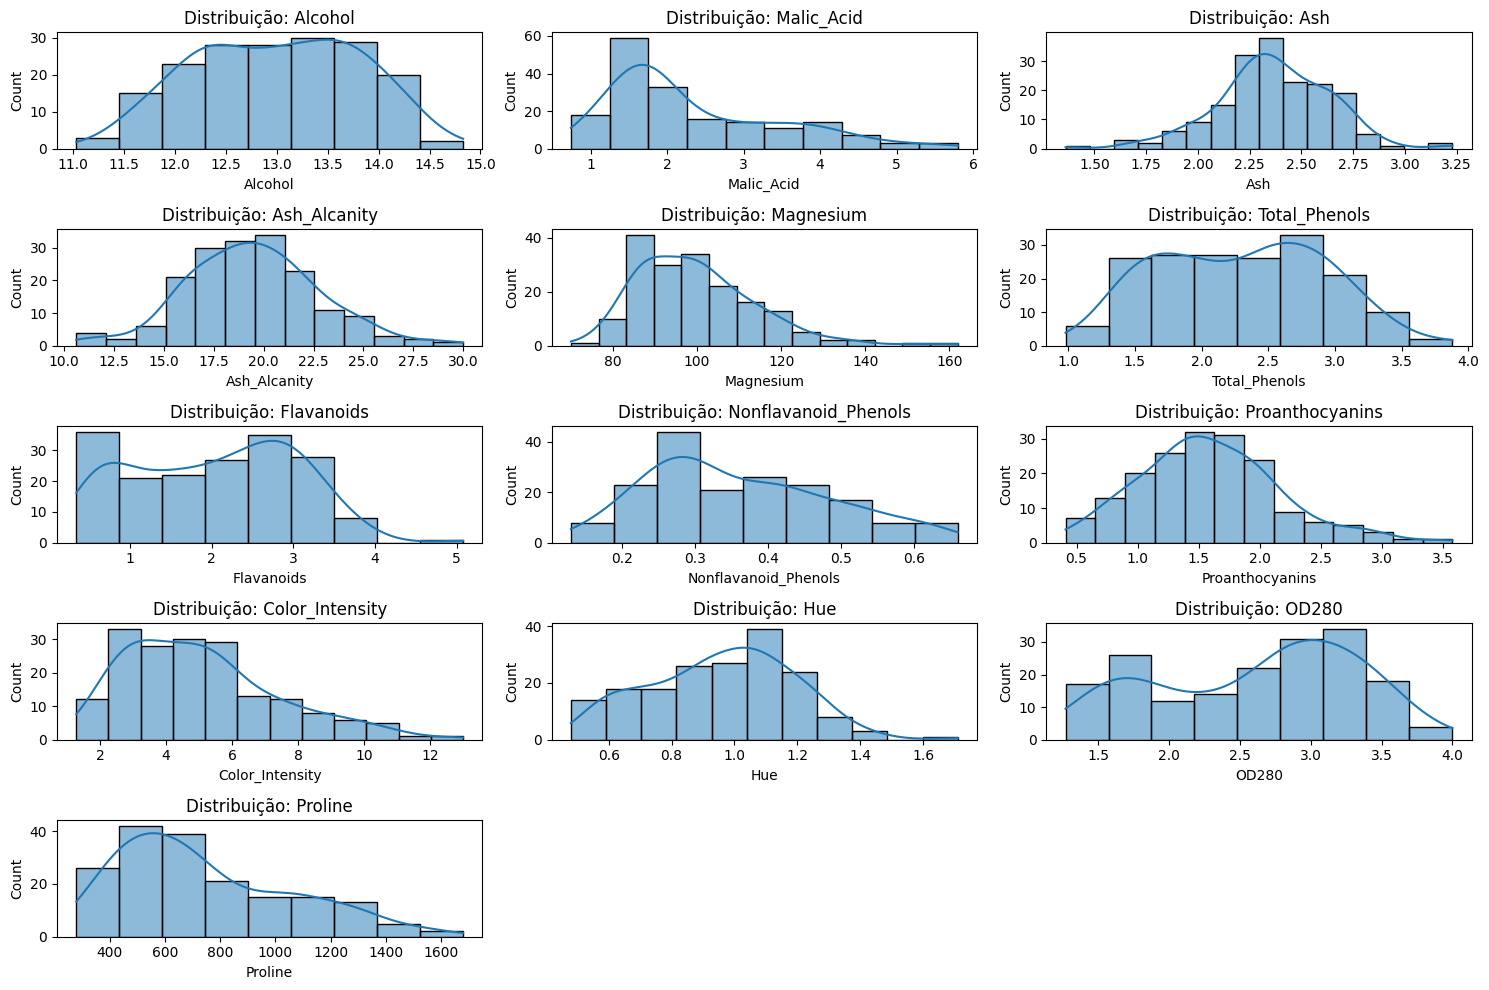

In [31]:
# COLUNAS PRESENTE NO DATASET
numero_colunas = ['Alcohol', 'Malic_Acid','Ash','Ash_Alcanity','Magnesium','Total_Phenols','Flavanoids','Nonflavanoid_Phenols','Proanthocyanins','Color_Intensity',
                 'Hue','OD280','Proline']

# TAMANNHO DA FIGURA
plt.figure(figsize = (15,10))

# FOR RODA CADA VARIAVEL E PLOTA O GRÁFICO COM AS CONFIGURAÇÕES ESTABELECIDAS
for i,coluna in enumerate(numero_colunas,1):
    plt.subplot(5,3,i)
    sns.histplot(vinhos[coluna], kde = True)
    plt.title(f'Distribuição: {coluna}')

plt.tight_layout()
plt.show()
    

### **OUTLIERS (BOXPLOTS)**

Nesta etapa, são avaliados possíveis outliers presentes nas variáveis numéricas do dataset. A identificação de valores extremos é fundamental, especialmente em algoritmos baseados em distância, como K-Means, que podem ser sensíveis a pontos muito distantes da distribuição central.

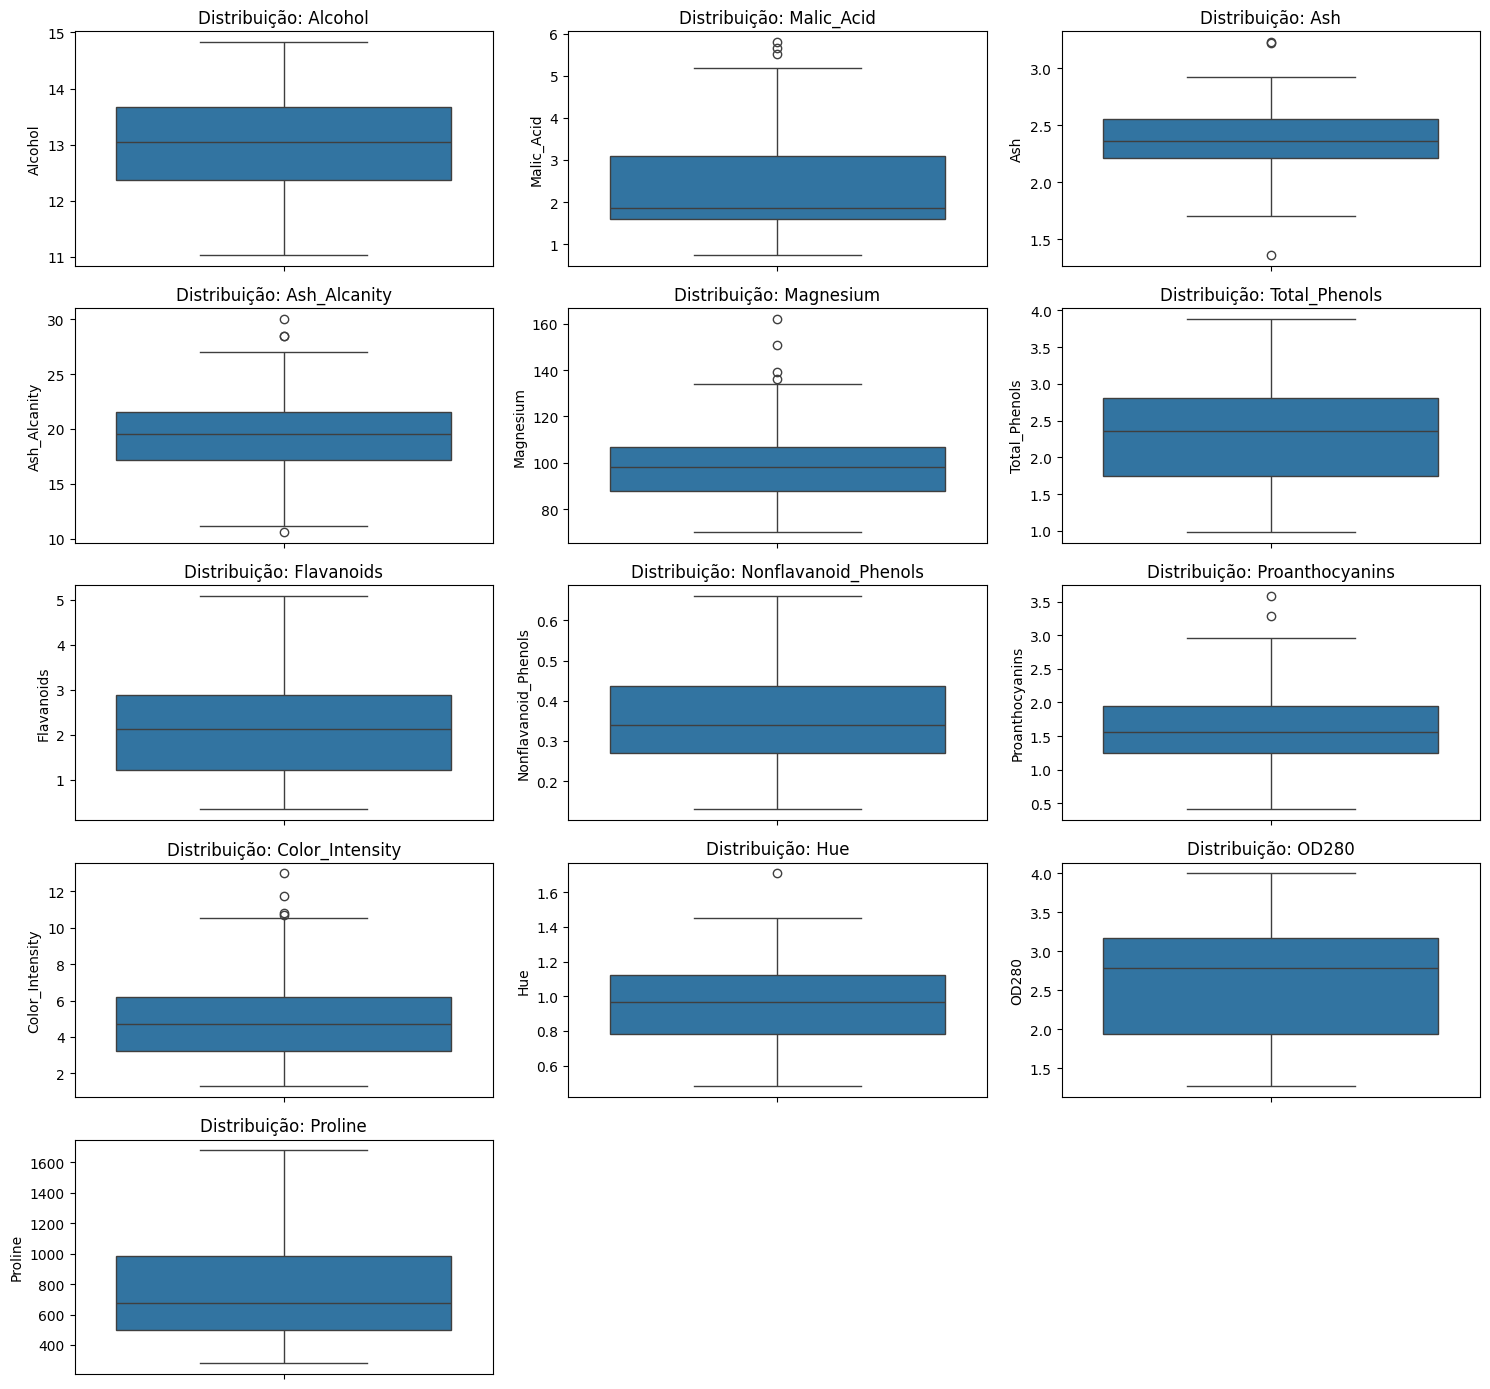

In [36]:
# COLUNAS PRESENTE NO DATASET
numero_colunas = ['Alcohol', 'Malic_Acid','Ash','Ash_Alcanity','Magnesium','Total_Phenols','Flavanoids','Nonflavanoid_Phenols','Proanthocyanins','Color_Intensity',
                 'Hue','OD280','Proline']

# TAMANNHO DA FIGURA
plt.figure(figsize = (15,14))

# FOR RODA CADA VARIAVEL E PLOTA O GRÁFICO COM AS CONFIGURAÇÕES ESTABELECIDAS
for i,coluna in enumerate(numero_colunas,1):
    plt.subplot(5,3,i)
    sns.boxplot(y = vinhos[coluna])
    plt.title(f'Distribuição: {coluna}')

plt.tight_layout()
plt.show()
    

### **NORMALIDADE: (HISTPLOT + KDE + QQ-PLOT)**
Nesta Etapa se as variáveis seguem distribuição normal. Utilizo:
- Histograma + KDE para observar comportamento
- Gráfico Q-Q (Quantile-Quantile plot) para verificar aderência à normalidade
- Teste estatístico Shapiro-wilk e klomogorv smirnov

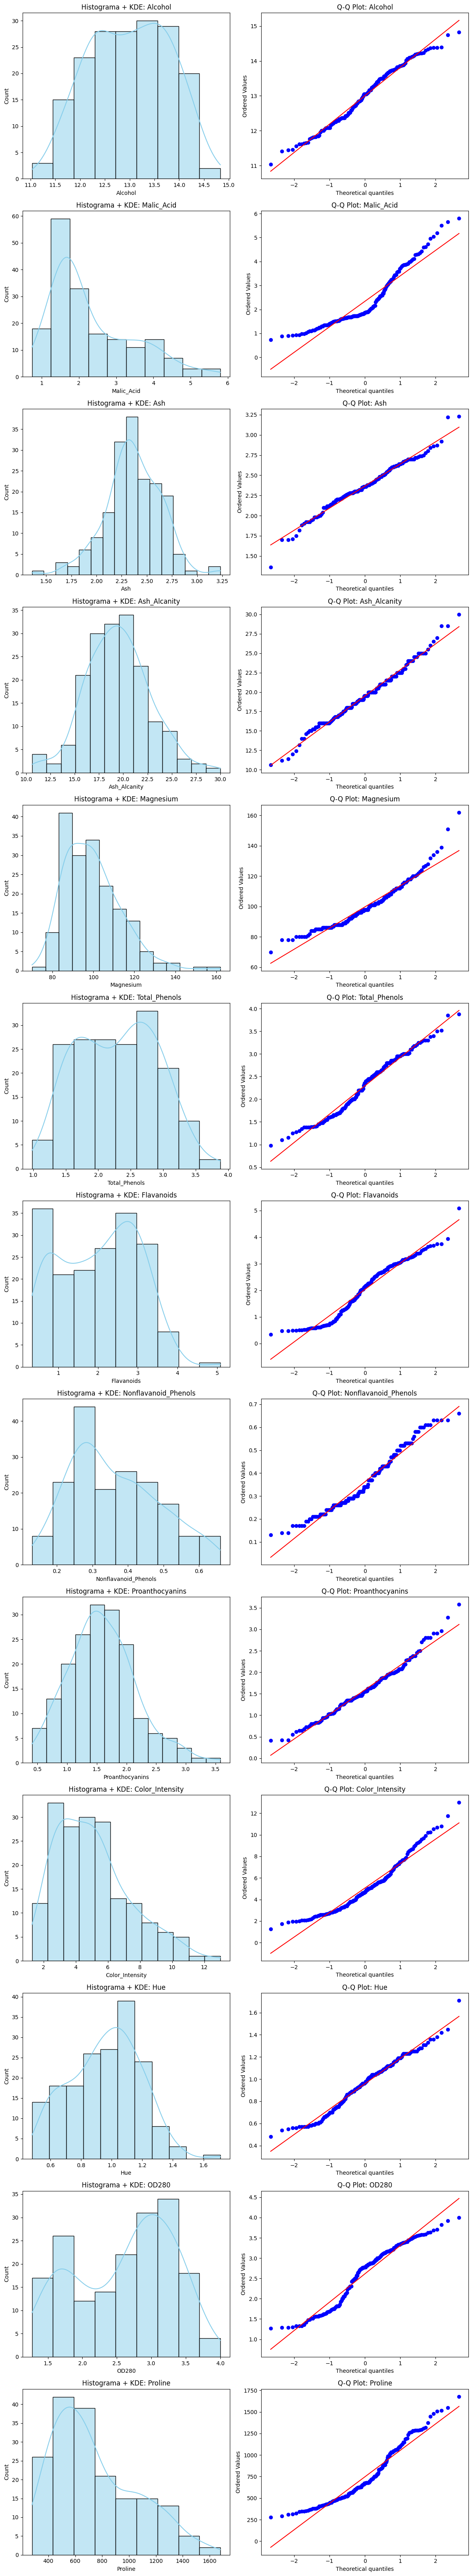

In [39]:
# Seleciona apenas colunas numéricas
numeric_cols = vinhos.select_dtypes(include=['int64', 'float64']).columns

# Define tamanho da figura e grade de subplots
numero_cols = 2  # 2 gráficos por linha: hist + qq
numero_rows = len(numero_colunas)  # 1 linha por variável
plt.figure(figsize=(12, 5 * numero_rows))

for i, colunas in enumerate(numeric_cols):
    # Histograma com KDE
    plt.subplot(numero_rows, 2, 2*i + 1)
    sns.histplot(vinhos[colunas], kde=True, color='skyblue')
    plt.title(f'Histograma + KDE: {colunas}')
    
    # Q-Q plot
    plt.subplot(numero_rows, 2, 2*i + 2)
    sts.probplot(vinhos[colunas], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot: {colunas}')

plt.tight_layout()
plt.show()

**TESTES DE NORMALIDADE**

Aplicando testes estatisticos de normalidade para cada variável, utilizei o lilliefors, pois é o mais indicado para menor quantidade de dados.
- O primeiro valor da tupla é a estatística do teste
- O segundo valor é: p_valor

In [3]:
# COLUNAS PRESENTE NO DATASET
numero_colunas = ['Alcohol', 'Malic_Acid','Ash','Ash_Alcanity','Magnesium','Total_Phenols','Flavanoids','Nonflavanoid_Phenols','Proanthocyanins','Color_Intensity',
                 'Hue','OD280','Proline']

# FOR RODA CADA VARIAVEL E PRINTA O TESTE ESTATISTICO
for coluna in numero_colunas:
    print('Estatistica de {} é: {}'.format(coluna, lilliefors(vinhos[coluna])))


Estatistica de Alcohol é (np.float64(0.06792401058724745), np.float64(0.05838225305113938))
Estatistica de Malic_Acid é (np.float64(0.19127641812672302), np.float64(0.0009999999999998899))
Estatistica de Ash é (np.float64(0.05845435626074311), np.float64(0.18650410337626436))
Estatistica de Ash_Alcanity é (np.float64(0.06349100089114879), np.float64(0.09886250242779672))
Estatistica de Magnesium é (np.float64(0.08954340677879147), np.float64(0.0024939418473668225))
Estatistica de Total_Phenols é (np.float64(0.07207477778676175), np.float64(0.035085821747413856))
Estatistica de Flavanoids é (np.float64(0.08534747079659089), np.float64(0.004657390955667288))
Estatistica de Nonflavanoid_Phenols é (np.float64(0.1148245732192627), np.float64(0.0009999999999998899))
Estatistica de Proanthocyanins é (np.float64(0.05674136210862185), np.float64(0.216577786646921))
Estatistica de Color_Intensity é (np.float64(0.09054212154353314), np.float64(0.0021822260171554214))
Estatistica de Hue é (np.floa

### **ANÁLISE DE CORRELAÇÃO ENTRE AS VARIÁVEIS**
Como etapa complementar da análise exploratória, é importante examinar a relação entre as variáveis químicas do dataset. A matriz de correlação permite identificar atributos fortemente relacionados, redundâncias e possíveis agrupamentos naturais entre as características. Essa análise é especialmente relevante em problemas de clustering, nos quais variáveis altamente correlacionadas podem influencias a distância entre observações e, consequentemente, o comportamento dos algortimos.

A partir da matriz de correlação, é possível avaliar se será necessário aplicara redução de dimensionalidade (PCA) ou normalizações especificas, além de compreender como os componentes químicos se associam entre si.

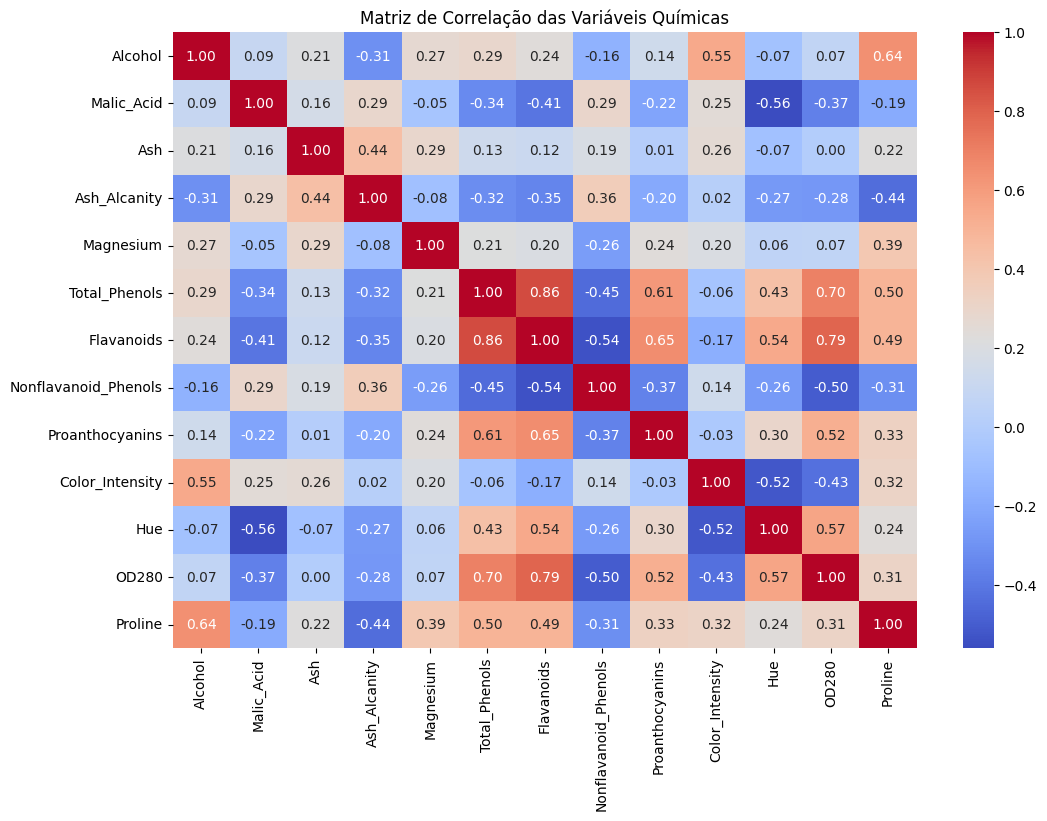

In [4]:
# CRIA A MATRIZ DE CORRELAÇÃO, BUSCANDO MULTICOLINEARIDADE ENTRE AS VARIAVEISescreva a
plt.figure(figsize=(12, 8))
sns.heatmap(vinhos.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlação das Variáveis Químicas")
plt.show()


### **CONCLUSÃO DA ANÁLISE EXPLORATÓRIA (EDA)**
A análise explorátoria permitiu compreender melhor o comportamente das variáveis químicas presentes no conjunto de dados dos vinhos e identificar padrões importantes antes da etapa de modelagem.

No geral, observou-se que:
- As variáveis apresentam distribuição distintas, algumas mais concentradas como, total sulfur dioxide, outras mais dispersas (alcohol e volatile acidity), o que indica diferentes escalas e amplitudes, reforçando a necessidade de normalização antes do clustering.
- A matriz de correlação revelou que apenas algumas variáveis possuem correlação forte entre si, enquanto a maior parte apresenta correlação fraca ou moderada. Isso indica baixa multicolinearidade geral no dataset, sugerindo que as variáveis carregam informações complementares.
- Nas poucas variáveis com correlação muito elevada, foi identificado um posssível risco de redundância, que poderá ser tratado por meio da remoção de uma das features correlacionadas ou redução de dimensionalidade via PCA, dependendo da estratégia adotada durante a modelagem.
- Não foram observados valores faltantes, e a presença de outliers, quando existente é esperada em dados reais e será considerada no processo de padronização das variáveis
  
Em síntese, a EDA indica que o conjunto de dados está em boa condição para prosseguir para as etapas de pré-processamento, padronização ou normalização, e posteriormente, aplicação de algortimos de clustering, uma vez que as variáveis oferecem diversidade informacional e potencial para separar vinhos em grupos distintos com base em suas caractéristicas químicas.

## **PRÉ-PROCESSAMENTO DOS DADOS**
Nesta etapa são aplicados os procedimentos necessários para preparar o dataset para os algortimos de agrupamento. Como métodos não supervisionados dependem fortemente da escala, da distribuição e da redudância entre variáveis, esta fase é essencial para garantir resultados consistentes.

Os objetivos do pré-processamento são:

- Garantir que todas as variáveis contribuam igualmente para o cálculo de distância, aplicando padronização.
- Gerar versões alternativas do dataset usando PCA, permitindo comparações entre análises com e sem redução de dimensionalidade.
- Organizar o material para que todos os modelos recebam sempre o mesmo formato de dados, evitandos inconsistências futuras.
  
A seguir, são descritros passos adotados.

### **SELEÇÃO DAS VARIÁVEIS**
Nesta etapa selecionamos apenas as colunas numéricas do dataset, que serão utilizadas pelos algoritmos de clusterização. Como k-means, hierárquico, DBSCAN e MeanShift operam sobre medidas de distância, variaveis categóricas não são adequadas.

In [3]:
#SELECIONAMENTO SOMENTE AS COLUNAS FLOAT E INT
features = vinhos.select_dtypes(include = ['float64', 'int64']).columns
#COPIA O DATASET COM AQUELAS COLUNAS
vinhos_copia = vinhos[features].copy()
#EXIBE O DATASET
vinhos_copia

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


### **PADRONIZAÇÃO (STANDARDSCALER)**
A padronização transforma cada variável para média 0 e desvio padrão 1.
Essa transformação é necessária porque:
- Evita variáveis com valores maiores dominem o cálculo de distância.
- É o método mais adequado para algortimos baseados em distância Euclidiana
- Facilita a convergência do K-Means
- Melhora a interpretabilidade dos dendogramas

In [4]:
# CRIA O ESCALONADOR
escalonador = StandardScaler()
# PADRONIZA OS DADOS
dados_padronizados = escalonador.fit_transform(vinhos_copia)
# EXIBE O RESULTADO
dados_padronizados[:5]

array([[ 1.51861254, -0.5622498 ,  0.23205254, -1.16959318,  1.91390522,
         0.80899739,  1.03481896, -0.65956311,  1.22488398,  0.25171685,
         0.36217728,  1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, -2.49084714,  0.01814502,
         0.56864766,  0.73362894, -0.82071924, -0.54472099, -0.29332133,
         0.40605066,  1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, -0.2687382 ,  0.08835836,
         0.80899739,  1.21553297, -0.49840699,  2.13596773,  0.26901965,
         0.31830389,  0.78858745,  1.39514818],
       [ 1.69154964, -0.34681064,  0.4879264 , -0.80925118,  0.93091845,
         2.49144552,  1.46652465, -0.98187536,  1.03215473,  1.18606801,
        -0.42754369,  1.18407144,  2.33457383],
       [ 0.29570023,  0.22769377,  1.84040254,  0.45194578,  1.28198515,
         0.80899739,  0.66335127,  0.22679555,  0.40140444, -0.31927553,
         0.36217728,  0.44960118, -0.03787401]])

### **ANÁLISE DE PCA (PRÉ-AVALIAÇÃO)**
Antes de aplicar PCA, analisamos variância é explicada pela redução dimensional. Essa etapa não substitui o dataset original, mas gera uma representalçao reduzida usada apenas para:

- Comparação entre métodos com e sem redução
- Visualização dos clusters em 2D

Text(0, 0.5, 'Proporção da variância')

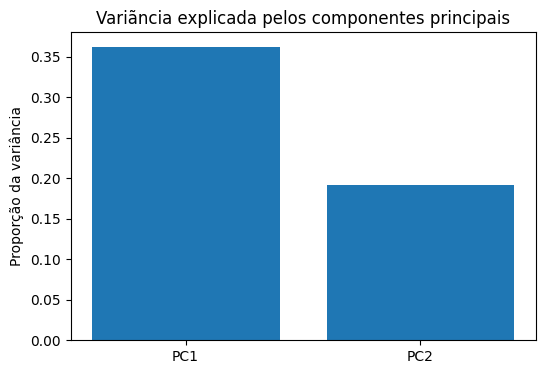

In [5]:
# DIFINE A CRIAÇÃO DE 2 COMPONENTES
pca = PCA(n_components=2)
# APLICA A REDUÇÃO NO DATASET ESCALONADO
dados_pca_2d = pca.fit_transform(dados_padronizados)
# PLOTA UM GRÁFICO COMPARATIVO ENTRE OS COMPONENTES
plt.figure(figsize = (6,4))
plt.bar(['PC1','PC2'], pca.explained_variance_ratio_)
plt.title('Variãncia explicada pelos componentes principais')
plt.ylabel('Proporção da variância')

### **CONSTRUÇÃO DOS CONJUNTOS FINAIS**

Foi gerado dois conjuntos padronizados:
- Dados padronizados - para modelos sem redução
- Dados padronizados + PCA - para modelos com redução

In [6]:
# DADOS PADRONIZADOS SEM PCA
dados_padronizados

array([[ 1.51861254, -0.5622498 ,  0.23205254, ...,  0.36217728,
         1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, ...,  0.40605066,
         1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, ...,  0.31830389,
         0.78858745,  1.39514818],
       ...,
       [ 0.33275817,  1.74474449, -0.38935541, ..., -1.61212515,
        -1.48544548,  0.28057537],
       [ 0.20923168,  0.22769377,  0.01273209, ..., -1.56825176,
        -1.40069891,  0.29649784],
       [ 1.39508604,  1.58316512,  1.36520822, ..., -1.52437837,
        -1.42894777, -0.59516041]], shape=(178, 13))

In [7]:
# DADOS PADRONIZADOS COM PCA
dados_pca_2d

array([[ 3.31675081,  1.44346263],
       [ 2.20946492, -0.33339289],
       [ 2.51674015,  1.0311513 ],
       [ 3.75706561,  2.75637191],
       [ 1.00890849,  0.86983082],
       [ 3.05025392,  2.12240111],
       [ 2.44908967,  1.17485013],
       [ 2.05943687,  1.60896307],
       [ 2.5108743 ,  0.91807096],
       [ 2.75362819,  0.78943767],
       [ 3.47973668,  1.30233324],
       [ 1.7547529 ,  0.61197723],
       [ 2.11346234,  0.67570634],
       [ 3.45815682,  1.13062988],
       [ 4.31278391,  2.09597558],
       [ 2.3051882 ,  1.66255173],
       [ 2.17195527,  2.32730534],
       [ 1.89897118,  1.63136888],
       [ 3.54198508,  2.51834367],
       [ 2.0845222 ,  1.06113799],
       [ 3.12440254,  0.78689711],
       [ 1.08657007,  0.24174355],
       [ 2.53522408, -0.09184062],
       [ 1.64498834, -0.51627893],
       [ 1.76157587, -0.31714893],
       [ 0.9900791 ,  0.94066734],
       [ 1.77527763,  0.68617513],
       [ 1.23542396, -0.08980704],
       [ 2.18840633,

## **DEFINIÇÃO DO NÚMERO DE CLUSTERS**

A clusterização é um processo sensível à escolha do número de grupos. Tanto o K-Means quanto oa agrupamento hiérarquico, exigem uma análise prévia para identificar quantos clusters descrevem melhor a estrutura dos dados. Para isso, foram utilizados três métodos complementares:

- Elbow Method (K-Means)
- Coeficiente de Silhueta (K-Means e hierárquico)
- Dendogramas (Hierárquico)

Cada ténica fornece um ponto de vista diferente, permitindo uma decisão mais confiável e estatisticamente consistente.

#### **Elbow Method - K-Means**

O elbow method avalia como o WCSS (within-cluster sum of squares) diminui conforme aumentamos o número de clusters.
A ideia é observar o ponto onde a queda deixa de ser significativa - o "cotovelo".

O método foi aplicado em duas versões:
- Elbow com dados padronizados (sem PCA)
- Elbow com os dados padronizados + PCA (2 componentes)

Essa abordagem permite comparar:
- A estrutura real dos dados no espaço original
- A estrutura após redução de dimensionalidade

**ELBOW METHOD SEM UTILIZAR PCA**

In [8]:
# CRIA O WCSS
wcss = []
# CRIA UM FOR, LOGO EM SEGUIDA CRIA O MODELO K-MEANS E DEFINE ALGUNS HIPERPARAMETROS, PEGA A INERCIA DE CADA MODELO E ADICIONA AO WCSS
for i  in range(1,11):
  kmeans = KMeans(n_clusters= i, init ='k-means++', random_state = 5, max_iter= 300)
  kmeans.fit(dados_padronizados)
  #inertia: Método para gerar o wcss
  wcss.append(kmeans.inertia_)
print(len(wcss))


10


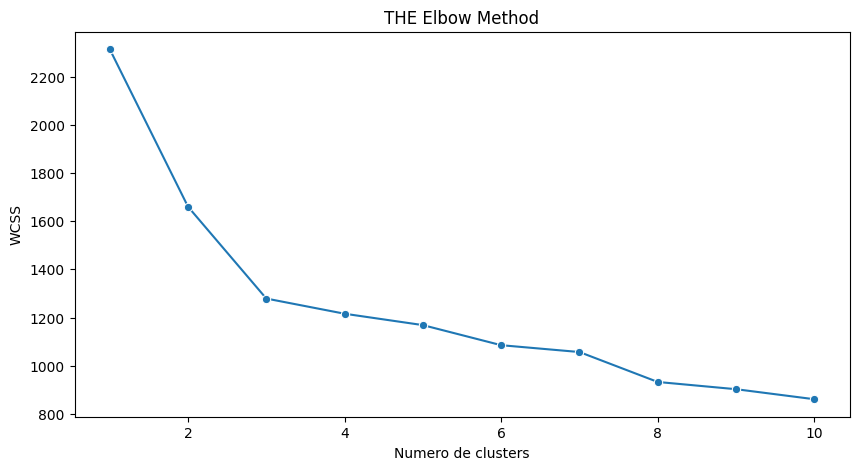

In [9]:
# PLOTA O GRÁFICA UTILIZANDO OS VALORES DO WCSS, CRIANDO O ELBOW METHOD
plt.figure(figsize = (10, 5))
sns.lineplot(x = range(1,11), y = wcss, marker='o')
plt.title("THE Elbow Method")
plt.xlabel("Numero de clusters")
plt.ylabel("WCSS");

**ELBOW METHOD UTILIZANDO O PCA (REDUÇÃO DE DIMENSIONALIADADE) PARA O KMEANS**

In [10]:
# CRIA O WCSS
wcss = []
# CRIA UM FOR PARA CAPTURAR O VALOR DA INERTIA E ADICIONAR AO WCSS
for i  in range(1,11):
  kmeans = KMeans(n_clusters= i, init ='k-means++', random_state = 5, max_iter= 300)
  kmeans.fit(dados_pca_2d)
  #inertia: Método para gerar o wcss
  wcss.append(kmeans.inertia_)
print(len(wcss))


10


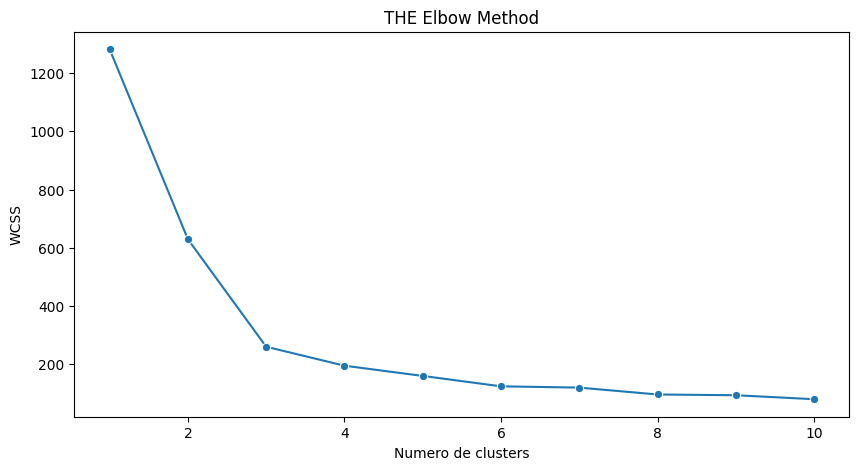

In [11]:
# UTILIZA OS VALORES DO WCSS PARA PLOTAR O GRÁFICO
plt.figure(figsize = (10, 5))
sns.lineplot(x = range(1,11), y = wcss, marker='o')
plt.title("THE Elbow Method")
plt.xlabel("Numero de clusters")
plt.ylabel("WCSS");

#### **DENDOGRAMAS - AGRUPAMENTO HIÉRARQUICO**
Para agrupamento hierárquico, o número de clusters é determinado inspecionando o dendograma.

Foram utilizados dois cenários:
- Dendograma com atributos padronizados
- Dendograma com PCA

A interpretação consiste em: 
- Idenficar o maior "Corte Vertical" possível que não cruza linhas
- Avaliar saltos grandes na distância de ligação
- Verificar consistência com método de silhueta

Os dendogramas auxiliam na escolha final de k, complementando a análise feita pelo K-means.

**AGRUPAMENTO HIERARQUICO DENDOGRAMA SEM PCA**

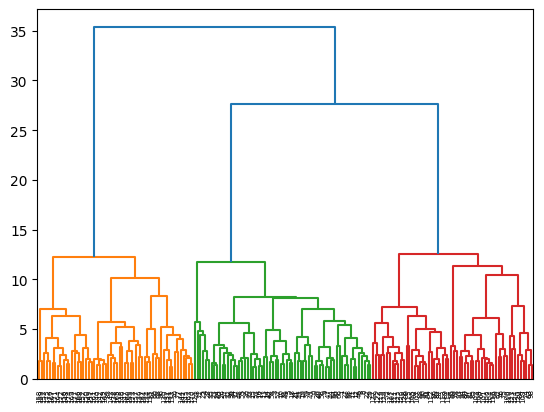

In [12]:
#dendograma para definir a quantidade de cluster que será utilizado no agrupamento hierarquico com todos os atributos
dendograma = dendrogram(linkage(dados_padronizados, method = 'ward'))

**AGRUPAMENTO HIERARQUICO DENDOGRAMA COM PCA**

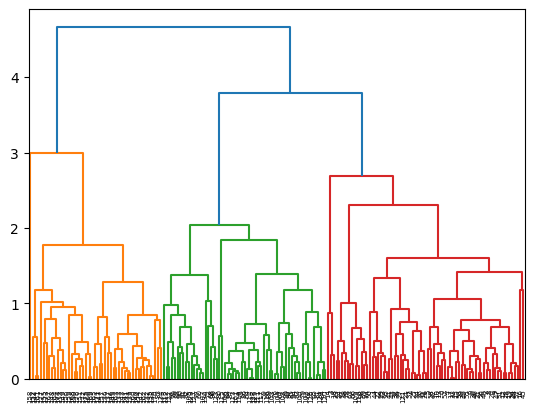

In [13]:
#dendograma para definir a quantidade de cluster que será utilizado no agrupamento hierarquico com PCA
dendograma = dendrogram(linkage(dados_pca_2d, method = 'average'))

#### **COEFICIENTE DE SILHUETA**
O coeficiente de silhueta mede quanto cada instância está bem alocada dentro do seu cluster, variando de -1 a 1:
- Valores próximo de 1 -> clusters bem definidos
- Valores próximos de 0 -> clusters fronteiras sobrepostas
- Valores negativos -> Pontos mal alocados

O método foi aplicado para k variando de 2 a 10, utilizando:
- Dados padronizados
- Dados + PCA

Assim foi possível comparar a qualidade dos agrupamentos e varificar se o número recomendado pelo Elbow realmente produz separaçãao consistente entre os grupos.

**K-Means sem PCA**

In [14]:
# CRIA UM DICT PARA ADOTAR OS RESULTADOS DO SILHUETA
silhouette_results = {}
# CRIA O KMEANS FAZ O TREINO E PREVISÕES DOS DADOS SEM PCA, PARA OBTER A MÉDIA DE CADA SILHUETA E ASSIM DECIDIR O NUMÉRO DE CLUSTERS
for k in range (2,11):
    kmeans = KMeans (n_clusters = k, random_state = 0)
    labels = kmeans.fit_predict(dados_padronizados)

    sil_score = silhouette_score(dados_padronizados, labels)
    silhouette_results[k] = sil_score
    print(f"k={k} -> Silhoutte Score = {sil_score:.4f}")

k=2 -> Silhoutte Score = 0.2683
k=3 -> Silhoutte Score = 0.2849
k=4 -> Silhoutte Score = 0.2860
k=5 -> Silhoutte Score = 0.2452
k=6 -> Silhoutte Score = 0.1900
k=7 -> Silhoutte Score = 0.1448
k=8 -> Silhoutte Score = 0.1291
k=9 -> Silhoutte Score = 0.1186
k=10 -> Silhoutte Score = 0.1108


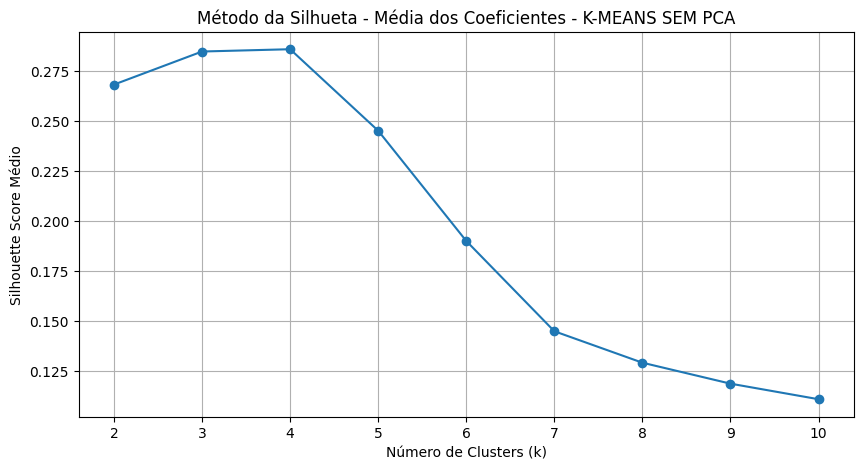

In [15]:
# GRÁFICO PARA AUXILIAR A VISUALIZAÇÃO DAS SILHUETAS
ks = list(silhouette_results.keys())
scores = list(silhouette_results.values())

plt.figure(figsize=(10, 5))
plt.plot(ks, scores, marker='o')
plt.title('Método da Silhueta - Média dos Coeficientes - K-MEANS SEM PCA')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score Médio')
plt.grid(True)
plt.show()


**K-MEANS COM PCA**

In [16]:
# CRIA UM DICT PARA ADOTAR OS RESULTADOS DO SILHUETA
silhouette_results = {}
# CRIA O KMEANS FAZ O TREINO E PREVISÕES DOS DADOS COM PCA, PARA OBTER A MÉDIA DE CADA SILHUETA E ASSIM DECIDIR O NUMÉRO DE CLUSTERS
for k in range (2,11):
    kmeans = KMeans (n_clusters = k, random_state = 0)
    labels = kmeans.fit_predict(dados_pca_2d)

    sil_score = silhouette_score(dados_pca_2d, labels)
    silhouette_results[k] = sil_score
    print(f"k={k} -> Silhoutte Score = {sil_score:.4f}")

k=2 -> Silhoutte Score = 0.4750
k=3 -> Silhoutte Score = 0.5602
k=4 -> Silhoutte Score = 0.5042
k=5 -> Silhoutte Score = 0.4559
k=6 -> Silhoutte Score = 0.4479
k=7 -> Silhoutte Score = 0.4239
k=8 -> Silhoutte Score = 0.3826
k=9 -> Silhoutte Score = 0.3656
k=10 -> Silhoutte Score = 0.4004


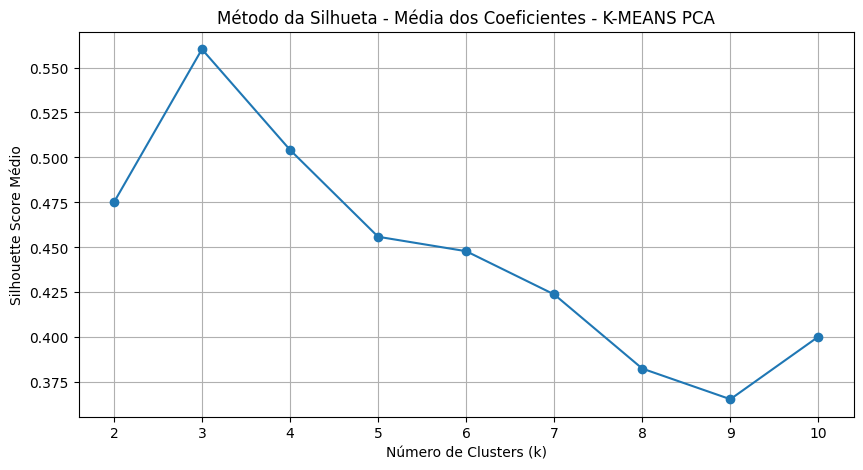

In [17]:
# GRÁFICO PARA AUXILIAR A VISUALIZAÇÃO DAS SILHUETAS
ks = list(silhouette_results.keys())
scores = list(silhouette_results.values())

plt.figure(figsize=(10, 5))
plt.plot(ks, scores, marker='o')
plt.title('Método da Silhueta - Média dos Coeficientes - K-MEANS PCA')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score Médio')
plt.grid(True)
plt.show()


**AGRUPAMENTO HIÉRARQUICO SEM PCA**

In [18]:
# # LISTA PARA ARMAZENAR OS RESULTADOS
silhouette_scores_hier = []

# TESTE ATÉ 4 CLUSTERS
for k in range(2, 5):
    modelo_hier = AgglomerativeClustering(
        n_clusters=k,
        metric='euclidean',
        linkage='ward'
    )
    labels = modelo_hier.fit_predict(dados_padronizados)  
    score = silhouette_score(dados_padronizados, labels)
    
    silhouette_scores_hier.append((k, score))
    print(f"k={k} -> Silhouette Score = {score:.4f}")


k=2 -> Silhouette Score = 0.2670
k=3 -> Silhouette Score = 0.2774
k=4 -> Silhouette Score = 0.2258


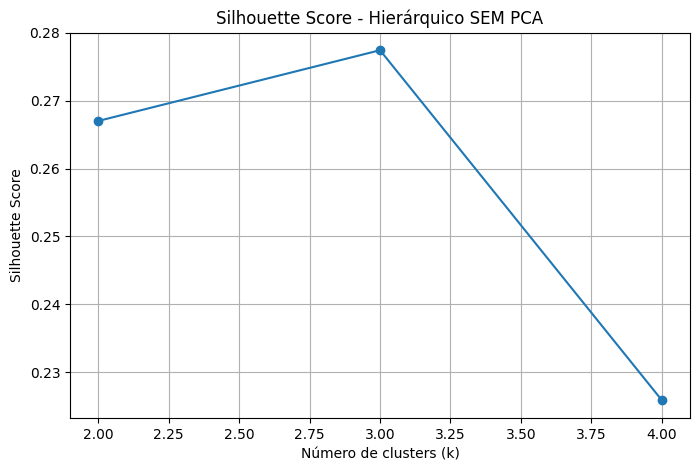

In [19]:
# SELECIONA OS RESULTADOS
ks = [item[0] for item in silhouette_scores_hier]
scores = [item[1] for item in silhouette_scores_hier]
# PLOTA O GRÁFICO DE PARA ANALISAR OS VALORES DA SILHUETA
plt.figure(figsize=(8, 5))
plt.plot(ks, scores, marker='o')
plt.title("Silhouette Score - Hierárquico SEM PCA")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


**AGRUPAMENTO HIÉRARQUICO COM PCA**

In [20]:
# LISTA PARA ARMAZENAR OS RESULTADOS
silhouette_scores_hier = []

# TESTAR O K ATÉ 4 CLUSTERS
for k in range(2, 5):
    modelo_hier = AgglomerativeClustering(
        n_clusters=k,
        metric='euclidean',
        linkage='average'
    )
    
    labels = modelo_hier.fit_predict(dados_pca_2d)  # use seu X padronizado aqui

    score = silhouette_score(dados_pca_2d, labels)
    
    silhouette_scores_hier.append((k, score))
    print(f"k={k} -> Silhouette Score = {score:.4f}")

k=2 -> Silhouette Score = 0.4736
k=3 -> Silhouette Score = 0.5542
k=4 -> Silhouette Score = 0.5007


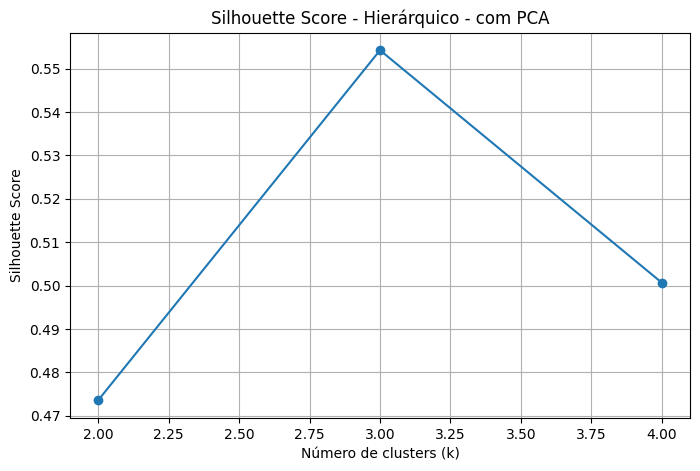

In [21]:
# SELECIONA OS RESULTADOS 
ks = [item[0] for item in silhouette_scores_hier]
scores = [item[1] for item in silhouette_scores_hier]
# PLOTA O GRAFICO PARA ANALISAR VISUALMENTE OS VALORES DO AGRUPAMENTO HIERARQUiCO
plt.figure(figsize=(8, 5))
plt.plot(ks, scores, marker='o')
plt.title("Silhouette Score - Hierárquico - com PCA")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

#### **ELBOW METHOD - DBSCAN (JOELHO)**
Nesta seção, utilizei o gráfico k-distance, utilizando a distância k-ésima para encontrar o melhor valor para eps. Funciona da mesma maneira para encontrar a quantidade de clusters para o k-means

- Utiliza os dados padronizados
- Define o numero de min_samples testados
- Utiliza o NearestNeighbors para encontrar as distância dos vizinho mais próximos
- Plota o gráfico

**DBSCAN - SEM PCA**

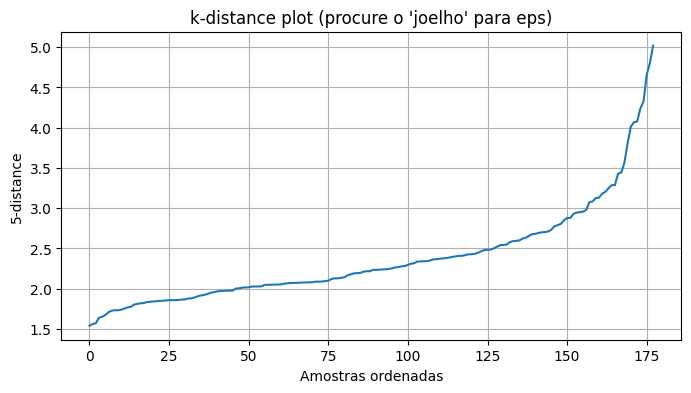

In [158]:
# DADOS PADRONIZADOS
X = dados_transformados 

# k =  NUMERO DE MIN_SAMPLES TESTADOS
k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, indices = nbrs.kneighbors(X)

# TOMANDO A DISTÂNCIA K-ÉSIMA (ULTIMA COLUNA)
k_distances = np.sort(distances[:, -1])

# CONFIGURAÇÕES DO GRÁFICO
plt.figure(figsize=(8,4))
plt.plot(k_distances)
plt.ylabel(f"{k}-distance")
plt.xlabel("Amostras ordenadas")
plt.title("k-distance plot (procure o 'joelho' para eps)")
plt.grid(True)
plt.show()


**Cria um dataframe, utilizando as informações para testar e escolher os melhores valores para os hiperparametros: eps e min_samples**
- RODA UM FOR PARA TESTANDO CADA EPS, MIN_SAMPLES PRÉ-SELECIONADOS, TREINO O ALGORTIMO COM DADA UM DESSES INTERVALOS
- CAPTURA OS RESULTADOS DE CADA VEZ QUE O ALGORTIMO RODAR, CONTA OS GRUPOS ÚNICOS SEPARADOS PELO AGRUPAMENTO
- DIVIDE QUEM É RUÍDO E QUEM É CLUSTER E FAZ A DEVIDA CONTAGEM
- FAZ O CALCULO DA PORCENTAGEM PROPORCIONAL DE RUIÍDO COM BASE NOS DADOS E FAZ O CALCULO DO SCORE DA SILHOUETTA
- MONTA TUDO EM UM DATASET E ORDENA OS POR SILHOUETTE E PROP_NOISE

In [163]:
# DADOS PADRONIZADOS
X = dados_transformados

# AJUSTE DOS INTERVALOS DOS HIPERPARAMETROS (TAMANHO DE EPS, MIN_SAMPLES)
eps_list = np.linspace(0.5,3.0, 10)   # ajuste esse intervalo conforme o k-distance
min_samples_list = [3, 5, 8, 13, 20, 26,14]

# RESULTADOS
results = []

# RODA UM FOR PARA TESTANDO CADA EPS, MIN_SAMPLES PRÉ-SELECIONADOS, TREINO O ALGORTIMO COM DADA UM DESSES INTERVALOS
# CAPTURA OS RESULTADOS DE CADA VEZ QUE O ALGORTIMO RODAR, CONTA OS GRUPOS ÚNICOS SEPARADOS PELO AGRUPAMENTO
# DIVIDE QUEM É RUÍDO E QUEM É CLUSTER E FAZ A DEVIDA CONTAGEM
# FAZ O CALCULO DA PORCENTAGEM PROPORCIONAL DE RUIÍDO COM BASE NOS DADOS E FAZ O CALCULO DO SCORE DA SILHOUETTA
# MONTA TUDO EM UM DATASET E ORDENA OS POR SILHOUETTE E PROP_NOISE
for eps in eps_list:
    for ms in min_samples_list:
        db = DBSCAN(eps=eps, min_samples=ms).fit(X)
        labels = db.labels_
        unique, counts = np.unique(labels, return_counts=True)
        n_noise = counts[unique== -1].item() if -1 in unique else 0
        n_clusters = len(unique) - (1 if -1 in unique else 0)
        prop_noise = n_noise / X.shape[0]
        sil = np.nan
        if n_clusters >= 2:
            try:
                sil = silhouette_score(X[labels != -1], labels[labels != -1])
            except:
                sil = np.nan
        results.append({
            'eps': eps, 'min_samples': ms,
            'n_clusters': n_clusters, 'n_noise': n_noise, 'prop_noise': prop_noise, 'silhouette': sil
        })

df_res = pd.DataFrame(results)
# ordena para ver os melhores por silhouette e por pouco ruído
df_res.sort_values(['silhouette','prop_noise'], ascending=[False, True]).head(20)


,eps,min_samples,n_clusters,n_noise,prop_noise,silhouette
37,1.888889,8,2,150,0.842697,0.589653
29,1.611111,5,3,161,0.904494,0.474145
53,2.444444,20,3,82,0.460674,0.424993
61,2.722222,26,2,62,0.348315,0.366705
36,1.888889,5,6,106,0.595506,0.358318
55,2.444444,14,2,62,0.348315,0.356062
43,2.166667,5,2,56,0.314607,0.348515
52,2.444444,13,2,51,0.286517,0.344014
60,2.722222,20,2,38,0.213483,0.332499
51,2.444444,8,2,36,0.202247,0.319711


**Scatter plot, para visualização dos agrupamentos realizados pelo algortimo**

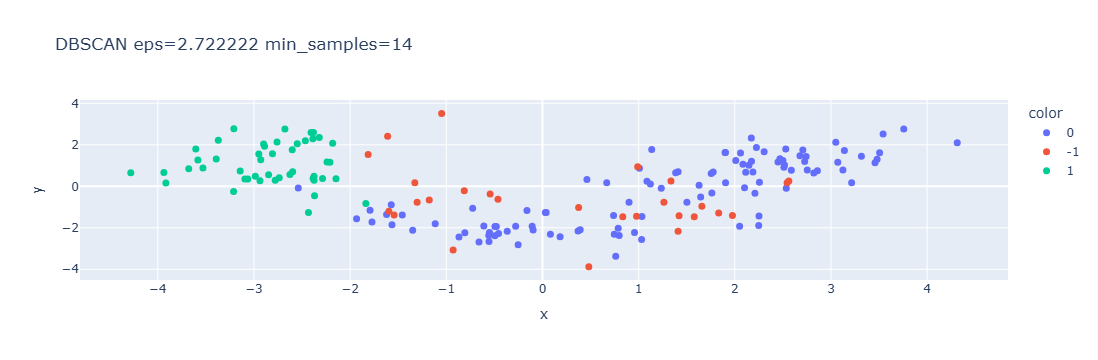

In [165]:
# ESCOLHA UMA COMBINAÇÃO DE eps_best e ms_best, UTILIZANDO O DATAFRAME COMO REFERÊNCIA
eps_best = 2.722222
ms_best = 14
# CRIA O DBSCAN COM AS VARIAVEIS eps_best e ms_best, TREINA O MODELO COM X (DADOS PADRONIZADOS) E OBTÉM AS LABELS
db = DBSCAN(eps=eps_best, min_samples=ms_best).fit(X)
labels = db.labels_

# CRIA UM PC COM 2 COMPONENTES SOMENTE UTILIZANDO O x (DADOS PADRONIZADOS)
pca = PCA(n_components=2)
X2 = pca.fit_transform(X)

# PLOTA UM SCATTER PLOT COM OS DADOS AGRUPADOS UTILIZANDO PLOTLY (INTERATIVO)
fig = px.scatter(x=X2[:,0], y=X2[:,1], color=labels.astype(str),
                 title=f"DBSCAN eps={eps_best} min_samples={ms_best}")
fig.update_traces(marker=dict(size=7))
fig.show()


#### **CONCLUSÃO**
A aplicação das métricas de Silhouette permitiu avaliar objetivamente a qualidade dos agrupamentos formados pelos métodos K-means e Agrupamento Hierárquico. Observou-se que, após a utilização do PCA para redução de dimensionalidade, os valores do Silhouette aumentaram de forma significativa, principalmente no K-means, indicando uma separação mais clara entre os grupos. No modelo hierárquico, embora as melhorias tenham sido mais discretas, o PCA também contribuiu para clusters mais consistentes. Com base nos resultados obtidos, o melhor valor de k ocorreu em 3 clusters, tanto pela análise visual quanto pelos maiores scores calculados. Portanto, o PCA mostrou-se eficaz para melhorar a estrutura dos dados e favorecer algoritmos de agrupamento, permitindo uma segmentação mais coerente das amostras neste dataset.

## **CRIAÇÃO DE PIPELINES**
Nesta seção foi realizado a criação dos pipelines para cada modelo:
- K-Means (com e sem PCA)
- Agrupamento Hiérarquico (com e sem PCA)
- DBSCAN (com e sem PCA)
- MeanShift (com e sem PCA)

Para a utilização deste númere exato de clusters (K-Means e Agrupamento Hiérarquico), na seção anterior "DEFINIÇÃO DO NÚMERO DE CLUSTER", apliquei o Elbow Method e Silhoutte, para o k-means e Dendograma e Silhoutte, para o agrupamento hiérarquico.

In [154]:
#pipeline sem PCA
pipe_kmeans = Pipeline(
    steps = [('scalonar', StandardScaler()),
             ('kmeans', KMeans(n_clusters= 3, init = 'k-means++',max_iter = 300,random_state = 35))]
)
#pipeline com PCA
pipe_kmeans_pca= Pipeline(
    steps= [('scalonar', StandardScaler()),
            ('pca',PCA(n_components= 2)),
            ('kmeans', KMeans(n_clusters= 3, init = 'k-means++',max_iter=300,random_state=35))]
)
#pipeline para agrupamento hierarquico
pipe_hierarquico = Pipeline(
    steps = [('scalonar', StandardScaler()),
             ('hier',AgglomerativeClustering(n_clusters=3,metric= 'euclidean',linkage='ward'))]
)
#pipele para agrupamento hierarquico com PCAs
pipe_hierarquico_pca = Pipeline(
    steps = [('scalonar', StandardScaler()),
             ('pca', PCA(n_components= 2)),
             ('hier', AgglomerativeClustering(n_clusters=3,metric = 'euclidean', linkage= 'average'))]
)
#pipeline para o DBSCAN
pipe_DBSCAN = Pipeline(
    steps = [
        ('scalonar', StandardScaler()),
        ('DBS', DBSCAN(eps = 2.722222,min_samples= 14))
    ])
#pipeline para DBSCAN com PCA
pipe_DBSCAN_pca = Pipeline(
    steps = [
        ('scalonar', StandardScaler()),
        ('pca', PCA(n_components= 2)),
        ('DBS', DBSCAN(eps = 0.53, min_samples= 4))
    ]
)
#pipeline para meanshift
pipeline_vinho_meanshift = Pipeline(
    steps = [
        ('scalonar', StandardScaler()),
        ('mean', MeanShift(bandwidth = 3.7, cluster_all= True))
    ]
)
#pipeline para meanshift com PCA
pipeline_vinho_meanshift_pca = Pipeline(
    steps = [
    ('scalonar',StandardScaler()),
    ('pca',PCA(n_components=2)),
    ('mean', MeanShift(bandwidth= 1.3, cluster_all= True))
])


## **K-MEANS - SEM PCA**

Nesta seção apliquei o algoritmo K-Means diretamente sobre os dados padronizados, sem redução de dimensionalidade. O objetivo é identificar padrões naturais de segmentação e avaliar o comportamento dos clusters com base na distância aos centróides.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [38]:
# CRIA O MODELOS E APLICA AS ETAPAS DE PRÉ-PROCESSAMENTO
pipe_kmeans.fit(vinhos)

,steps,"[('scalonar', ...), ('kmeans', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300


#### **CENTRÓIDES DOS GRUPOS (CLUSTERS CENTERS)**
- Cálculo dos centróides no espaço escalonado
- Reversão do escalonamento para valores reais
- Agrupamento de cada variavel e quantidade por grupo

In [28]:
# CENTROIDS DAS VARIÁVEIS
centroids = pipe_kmeans.named_steps['kmeans'].cluster_centers_
centroids

array([[-0.92607185, -0.39404154, -0.49451676,  0.17060184, -0.49171185,
        -0.07598265,  0.02081257, -0.03353357,  0.0582655 , -0.90191402,
         0.46180361,  0.27076419, -0.75384618],
       [ 0.16490746,  0.87154706,  0.18689833,  0.52436746, -0.07547277,
        -0.97933029, -1.21524764,  0.72606354, -0.77970639,  0.94153874,
        -1.16478865, -1.29241163, -0.40708796],
       [ 0.83523208, -0.30380968,  0.36470604, -0.61019129,  0.5775868 ,
         0.88523736,  0.97781956, -0.56208965,  0.58028658,  0.17106348,
         0.47398365,  0.77924711,  1.12518529]])

In [29]:
# INVERTE O ESCALONAMENTO
centroids_real = pipe_kmeans.named_steps['scalonar'].inverse_transform(
    pipe_kmeans.named_steps['kmeans'].cluster_centers_
)
centroids_real

array([[1.22509231e+01, 1.89738462e+00, 2.23123077e+00, 2.00630769e+01,
        9.27384615e+01, 2.24769231e+00, 2.05000000e+00, 3.57692308e-01,
        1.62415385e+00, 2.97307692e+00, 1.06270769e+00, 2.80338462e+00,
        5.10169231e+02],
       [1.31341176e+01, 3.30725490e+00, 2.41764706e+00, 2.12411765e+01,
        9.86666667e+01, 1.68392157e+00, 8.18823529e-01, 4.51960784e-01,
        1.14588235e+00, 7.23470586e+00, 6.91960784e-01, 1.69666667e+00,
        6.19058824e+02],
       [1.36767742e+01, 1.99790323e+00, 2.46629032e+00, 1.74629032e+01,
        1.07967742e+02, 2.84758065e+00, 3.00322581e+00, 2.92096774e-01,
        1.92209677e+00, 5.45354839e+00, 1.06548387e+00, 3.16338710e+00,
        1.10022581e+03]])

In [30]:
# VARIAVEIS AGRUPADAS
classificacao = pipe_kmeans.named_steps['kmeans'].labels_
# CAPTURANDO O AGRUPAMENTO
valores, contagens = np.unique(classificacao, return_counts= True)
# RESULTADO DO AGRUPAMENTO
print(classificacao)
# QUANTIDADE DE GRUPOS CRIADAS PELO ALGORTIMO
print(valores)
# CONTAGEM PARA CADA GRUPO
print(contagens)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 1 2]
[65 51 62]


#### **AVALIANDO MÉTRICAS**
Nesta etapa, utilizo as métricas de Silhouette, Calinski e Davies. Cada métrica tem sua importação na definição do modelo que melhor agrupa e é consistente na sua função:

Silhouette, mede o quão bem os pontos estão dentro do seu cluster e loge dos outros clusters, (0 a 1, quanto maior melhor).
- 0.70 - 1.0: Excelent clusterização
- 0.50 - 0.69: Boa
- 0.30 - 0.49: Regular
- 0.00 - 0.29: Fraca (clusters se sobrepõem)
- Negativo: Horrível (dados nos clusters errados)


Calinski-Harabasz, mede a separação entre clusters versos a compactação dentro deles, (Valores Infinitos: quanto maior melhor)
- Valores altos = clusters bem definidos
- Não tem faixa exata, é feito a comparação entre os modelos testados.


      
 Davies-Bouldin, mede o quão proximos os pontos dos clusters estão do seu centróide (quanto menor, mais compacto) e mede a distância entre os dentróides de dois clusters (quanto maior, mais separados)
- Baixo DBI: Clusters compactos e bem separados
- Alto DBI: Clusters espalhados e se confundindo
-  0.2 - 0.6: Excelente
-  0.6 - 1.2 Razóavel
-  maior ou igual a 1.5 Ruim (Clusters muito próximo ou mal definidos) 

In [54]:
# ESCALONA NOVAMENTE OS CENTROIDS
dados_transformados = pipe_kmeans.named_steps['scalonar'].transform(vinhos) 

# MÉTRICAS UTILIZADAS PARA AVALIAÇÃO DO AGRUPAMENTO
sil = silhouette_score(dados_transformados, classificacao)
calinski = calinski_harabasz_score(dados_transformados, classificacao)
davies = davies_bouldin_score(dados_transformados, classificacao)

# RESULTADO PARA AS MÉTRICAS
print(f'Silhouette Score: {sil:.4}')
print(f'Calinski Score: {calinski:.4}')
print(f'Davies-Bouldin: {davies:.4}')

Silhouette Score: 0.2849
Calinski Score: 70.94
Davies-Bouldin: 1.389


#### **VISUALIZAÇÃO DOS RESULTADOS DO K-MEANS (SEM PCA)**
Nesta etapa, plotei alguns gráficos para ajudar na visualização e julgamento de cada clusters criado pelo k-means
- Scatterplot, apliquei a PCA somente nos dados para que fosse possivel realizar a visualização das variaveis e dos centroids
- Gráfico de Silhueta, para avaliar cada cluster individualmente, mais coeso, está ácima da média global
- Valores reais do inicio e fim da silhueta média do cluster

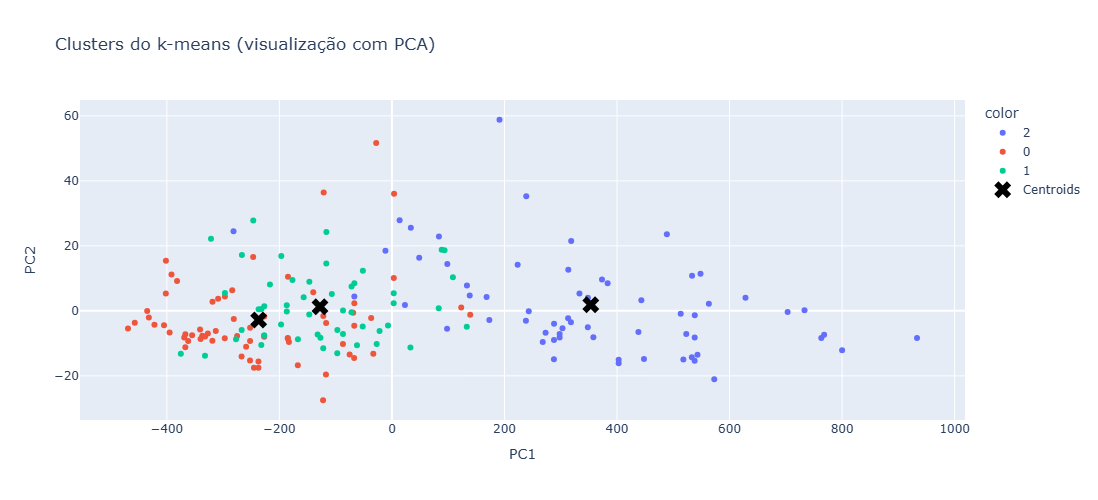

In [53]:
# PCA PARA VISUALIZAÇÃO
pca_vis = PCA(n_components = 2)
dados_2d = pca_vis.fit_transform(vinhos)

# TRANSFORMAR EM DATAFRAME E CONVERTE PARA PCA
centroids_df = pd.DataFrame(centroids_real, columns = vinhos.columns)
centroids_2d = pca_vis.transform(centroids_df)

# CONFIGURA O GRÁFICO
fig = px.scatter(x = dados_2d[:, 0], y= dados_2d[:, 1], color = classificacao.astype(str), title = 'Clusters do k-means (visualização com PCA)',
                labels = {'x': 'PC1', 'y': 'PC2'})
fig.add_trace(
    go.Scatter(x = centroids_2d[:, 0], y = centroids_2d[:,1], mode = 'markers',
               marker = dict(size = 15, symbol = 'x', color = 'black'), name = 'Centroids'))
# PLOTA O GRÁFICO
fig.update_layout(width = 800, height = 500)
fig.show()

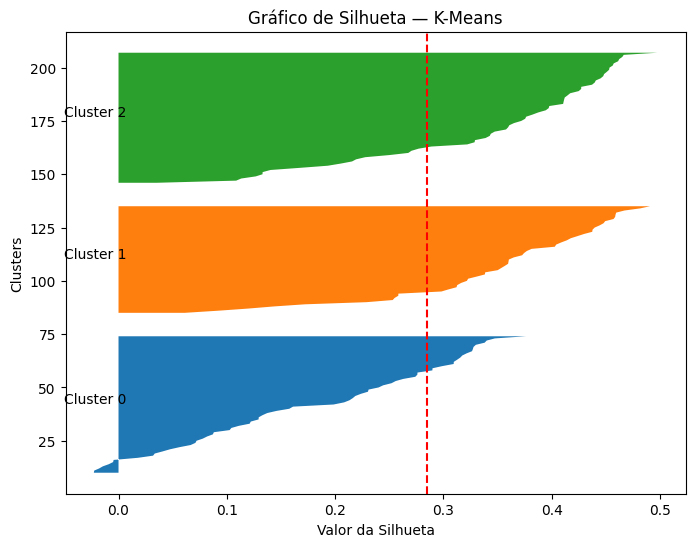

In [51]:
# CALCULA A SILHUETA INDIVIDUAL
sil_values = silhouette_samples(dados_padronizados, classificacao)
k = len(np.unique(classificacao))

fig, ax = plt.subplots(figsize=(8, 6))

y_lower = 10
for i in range(k):
    # VALOR DOS CLUSTERS
    cluster_sil = sil_values[classificacao == i]
    cluster_sil.sort()

    size = cluster_sil.shape[0]
    y_upper = y_lower + size

    # PLOTA AS BARRAS HORIZONTAIS PARA CADA CLUSTER
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0, cluster_sil
    )

    # texto indicando qual cluster é
    ax.text(-0.05, y_lower + 0.5 * size, f"Cluster {i}")

    y_lower = y_upper + 10

# LINHA VERTICAL PARA MÉDIA GLOBAL
sil_avg = silhouette_score(dados_padronizados, classificacao)
ax.axvline(sil_avg, color="red", linestyle="--")

ax.set_title("Gráfico de Silhueta — K-Means - SEM PCA")
ax.set_xlabel("Valor da Silhueta")
ax.set_ylabel("Clusters")
plt.show()


In [52]:
# O VALOR INICAL E FINAL DA SILHUETA DE CADA CLUSTER
for k in np.unique(classificacao):
    vals = sil_values[classificacao == k]
    print(f"Cluster {k}: {vals.min():.3f} → {vals.max():.3f}")


Cluster 0: -0.023 → 0.376
Cluster 1: 0.061 → 0.491
Cluster 2: 0.035 → 0.498


#### **INSERÇÃO DOS LABELS NO DATASET ORIGINAL**
Nesta etapa, Transformei os agrupamentos criados pelo k-means no dataset original. Mostrando a qual grupo cada registro pertence.
- Criação do dataframe 'agrupamento'
- Criando um novo dataset com a concatenação dos agrupamentos e registros reais
- Exibição da tabela final

In [55]:
agrupamento = pd.DataFrame(classificacao, columns=['Agrupamento'])
agrupamento

,Agrupamento
0,2
1,2
2,2
3,2
4,2
...,...
173,1
174,1
175,1
176,1


In [57]:
#agrupa o dataset copiado com os agrupamentos criados pelo KMeans com todos os atributos
vinhos_km = pd.concat([vinhos,agrupamento], axis = 1)
vinhos_km

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Agrupamento
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,2
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,2
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,2
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,2
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,1
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,1
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,1
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,1


#### **CONCLUSÃO FINAL DO K-MEANS (SEM PCA)**
Após aplicar o algortimo K-Means diretamente sobre as variáveis padronizadas, foi possível identificar grupos distintos no conjunto de dados.

As métricas indicaram uma qualidade moderada de clusterização, com destaque para:
- Silhouette Score, indicando separação razoável entre os clusters
- Davies-Bouldin sugerindo que há zonas de sobreposição
- Calinski-Harabaz apontando coesão satisfatoria

A análise dos gráficos de silhouetee mostrou diferenças claras na estabilidade de cada cluster, permitindo identificar grupos mais compactos e melhor separados.

A inspeção dos centróides (após inverter o escalonamento) permitiu interpretar o perfil médio de cada cluster, auxiliando na caracterização e possível nomeação dos segmentos.

Por fim, os agrupamento foram incorporados ao dataset original, possibilitando análises adicionais, comparações e futuras visualizações no contexto completo dos dados.

Esta etapa fornece uma base sólida para compararmos este modelo com abordagens futuras - como K-Means com PCA, DBSCAN, Agrupamento Hiérarquico (com e sem PCA), MeanShift.

## **K-MEANS -  COM PCA**
Nesta seção apliquei o algortimo K-Means sobre os daddos padronizados e com a ténica de redução de dimensionalidade (PCA), como indicado na seção de 'DEFINIÇÃO DE CLUSTERS' o PCA apontou um valor muito melhor para 3 clusters com a técnica de silhueta.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [15]:
#exibição do pipeline
pipe_kmeans_pca

,steps,"[('scalonar', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'


In [16]:
#treinando o modelo com os dados
pipe_kmeans_pca.fit_transform(vinhos)

array([[4.62906961, 6.06087341, 1.13591426],
       [2.65545659, 5.16904519, 1.29577613],
       [3.77336533, 5.25615013, 0.23872433],
       [5.88814973, 6.68695336, 2.3200656 ],
       [2.81601595, 3.75821058, 1.28314201],
       [4.94952486, 5.86665257, 1.38959924],
       [3.83598925, 5.18681095, 0.26804797],
       [3.95578253, 4.81767009, 0.68837974],
       [3.68695696, 5.25438008, 0.22590741],
       [3.77138517, 5.50415126, 0.49503781],
       [4.65508119, 6.21896992, 1.23909757],
       [2.96159619, 4.52634613, 0.63747717],
       [3.23916122, 4.87576299, 0.33401345],
       [4.52790481, 6.19596232, 1.18166659],
       [5.80459911, 7.11172554, 2.32093491],
       [4.13558327, 5.06740859, 0.70279368],
       [4.63309228, 5.04542664, 1.37234837],
       [3.89238209, 4.66010152, 0.77642614],
       [5.56753617, 6.42392145, 1.9997166 ],
       [3.51873866, 4.82334697, 0.22804065],
       [4.05218351, 5.87427987, 0.85325303],
       [2.28278059, 3.93409405, 1.40048948],
       [3.

In [27]:
#variancia do PCA
variancia = pipe_kmeans_pca.named_steps['pca'].explained_variance_ratio_.sum()
variancia

np.float64(0.5540633835693527)

#### **CENTRÓIDES DOS GRUPOS (CLUSTERS CENTERS)**
- Cálculo dos centróides no espaço escalonado
- Reversão do escalonamento para valores reais
- Agrupamento de cada variavel e quantidade por grupo

In [29]:
#obtem os centroides escalonados e com aplicação do PCA
centroids_pca = pipe_kmeans_pca.named_steps['kmeans'].cluster_centers_
centroids_pca

array([[-0.04083933, -1.74320866],
       [-2.73771147,  1.16476397],
       [ 2.28888211,  0.95994724]])

In [30]:
#inverte a aplicação do PC para 2 compnentes
centroids_escalonado = pipe_kmeans_pca.named_steps['pca'].inverse_transform(centroids_pca)
centroids_escalonado

array([[-0.84899988, -0.38208826, -0.55089013,  0.02823514, -0.52812345,
        -0.12949512, -0.0114155 , -0.03797676, -0.08131135, -0.920274  ,
         0.4746475 ,  0.27138876, -0.64781254],
       [ 0.16820765,  0.9332443 ,  0.37376078,  0.64285478, -0.03973035,
        -1.00471184, -1.16178546,  0.85081881, -0.81230228,  0.85992683,
        -1.1375619 , -1.22143707, -0.36001919],
       [ 0.79463294, -0.34528363,  0.29871475, -0.55794252,  0.61263588,
         0.96576665,  0.9648215 , -0.65568029,  0.75513073,  0.30593469,
         0.41109365,  0.70309519,  1.00662951]])

In [31]:
#Inverte o escalonamento padronizado das varaiveis
centroids_real_pca = pipe_kmeans_pca.named_steps['scalonar'].inverse_transform(centroids_escalonado)
centroids_real_pca

array([[1.23133161e+01, 1.91070061e+00, 2.21580858e+00, 1.95889716e+01,
        9.22198764e+01, 2.21429568e+00, 2.01789927e+00, 3.57140893e-01,
        1.54449052e+00, 2.93063298e+00, 1.06563518e+00, 2.80382681e+00,
        5.43466090e+02],
       [1.31367893e+01, 3.37598585e+00, 2.46876745e+00, 2.16357594e+01,
        9.91757211e+01, 1.66808118e+00, 8.72074471e-01, 4.67443321e-01,
        1.12727829e+00, 7.04603834e+00, 6.98166539e-01, 1.74691617e+00,
        6.33839436e+02],
       [1.36439074e+01, 1.95170109e+00, 2.44823693e+00, 1.76369005e+01,
        1.08466922e+02, 2.89783821e+00, 2.99027911e+00, 2.80481872e-01,
        2.02188887e+00, 5.76533889e+00, 1.05114944e+00, 3.10947205e+00,
        1.06299672e+03]])

In [32]:
#grupos
classificacao2 = pipe_kmeans_pca.named_steps['kmeans'].labels_
valores, contagens = np.unique(classificacao2, return_counts = True)
#grupos criados
print(classificacao2)
#Grupos criados
print(valores)
#quantidada em cada grupo
print(contagens)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 1 2]
[67 50 61]


#### **AVALIANDO MÉTRICAS**
Nesta etapa, utilizo as métricas de Silhouette, Calinski e Davies. Cada métrica tem sua importação na definição do modelo que melhor agrupa e é consistente na sua função:

Silhouette, mede o quão bem os pontos estão dentro do seu cluster e loge dos outros clusters, (0 a 1, quanto maior melhor).
- 0.70 - 1.0: Excelent clusterização
- 0.50 - 0.69: Boa
- 0.30 - 0.49: Regular
- 0.00 - 0.29: Fraca (clusters se sobrepõem)
- Negativo: Horrível (dados nos clusters errados)


Calinski-Harabasz, mede a separação entre clusters versos a compactação dentro deles, (Valores Infinitos: quanto maior melhor)
- Valores altos = clusters bem definidos
- Não tem faixa exata, é feito a comparação entre os modelos testados.


      
 Davies-Bouldin, mede o quão proximos os pontos dos clusters estão do seu centróide (quanto menor, mais compacto) e mede a distância entre os dentróides de dois clusters (quanto maior, mais separados)
- Baixo DBI: Clusters compactos e bem separados
- Alto DBI: Clusters espalhados e se confundindo
-  0.2 - 0.6: Excelente
-  0.6 - 1.2 Razóavel
-  maior ou igual a 1.5 Ruim (Clusters muito próximo ou mal definidos) 

In [33]:
# ESCALONA NOVAMENTE OS CENTROIDS
dados_transformados = pipe_kmeans_pca.named_steps['scalonar'].transform(vinhos) 

# MÉTRICAS UTILIZADAS PARA AVALIAÇÃO DO AGRUPAMENTO
sil = silhouette_score(dados_transformados, classificacao2)
calinski = calinski_harabasz_score(dados_transformados, classificacao2)
davies = davies_bouldin_score(dados_transformados, classificacao2)

# RESULTADO PARA AS MÉTRICAS
print(f'Silhouette Score: {sil:.4}')
print(f'Calinski Score: {calinski:.4}')
print(f'Davies-Bouldin: {davies:.4}')

Silhouette Score: 0.2829
Calinski Score: 70.78
Davies-Bouldin: 1.388


#### **VISUALIZAÇÃO DOS RESULTADOS DO K-MEANS (COM PCA)**
Nesta etapa, plotei alguns gráficos para ajudar na visualização e julgamento de cada clusters criado pelo k-means (COM PCA)
- Scatterplot, apliquei a PCA somente nos dados para que fosse possivel realizar a visualização das variaveis e dos centroids
- Gráfico de Silhueta, para avaliar cada cluster individualmente, mais coeso, está ácima da média global
- Valores reais do inicio e fim da silhueta média do cluster

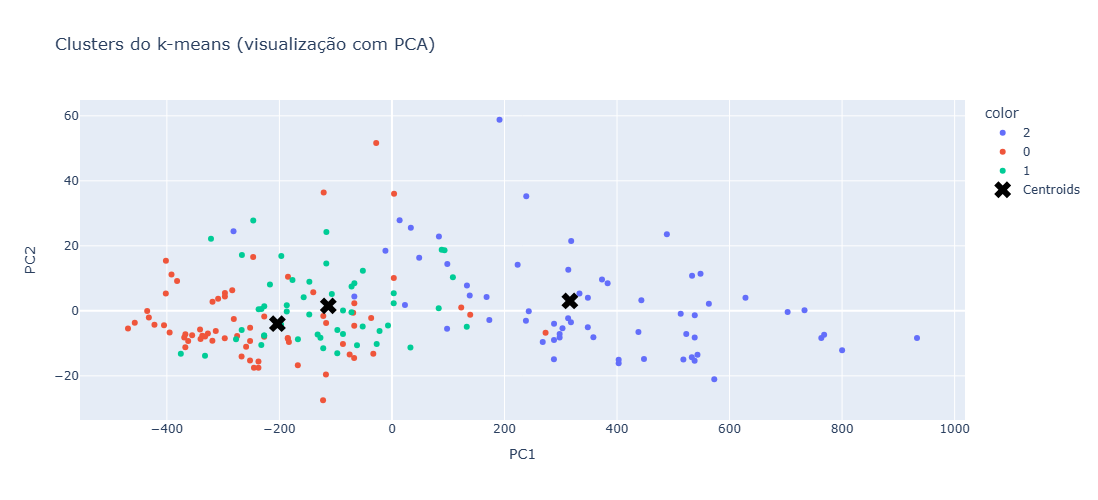

In [35]:
# PCA PARA VISUALIZAÇÃO
pca_vis = PCA(n_components = 2)
dados_2d = pca_vis.fit_transform(vinhos)

# TRANSFORMAR EM DATAFRAME E CONVERTE PARA PCA
centroids_df = pd.DataFrame(centroids_real_pca, columns = vinhos.columns)
centroids_2d = pca_vis.transform(centroids_df)

# CONFIGURA O GRÁFICO
fig = px.scatter(x = dados_2d[:, 0], y= dados_2d[:, 1], color = classificacao2.astype(str), title = 'Clusters do k-means (visualização com PCA)',
                labels = {'x': 'PC1', 'y': 'PC2'})
fig.add_trace(
    go.Scatter(x = centroids_2d[:, 0], y = centroids_2d[:,1], mode = 'markers',
               marker = dict(size = 15, symbol = 'x', color = 'black'), name = 'Centroids'))
# PLOTA O GRÁFICO
fig.update_layout(width = 800, height = 500)
fig.show()

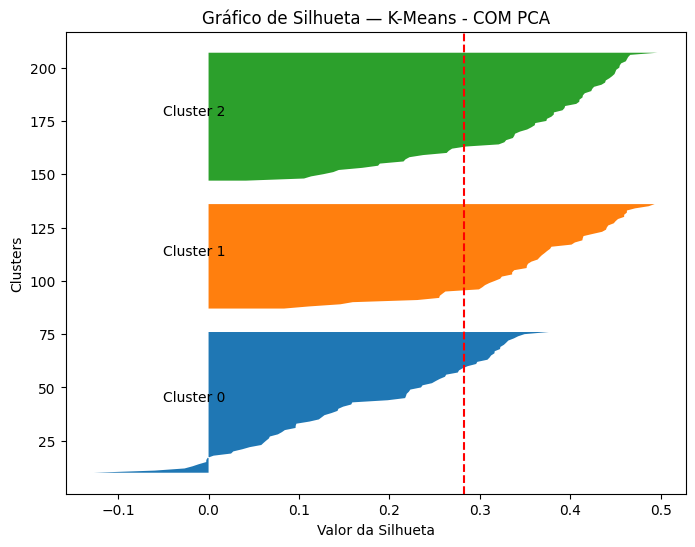

In [37]:
#CALCULA A SILHUETA INDIVIDUAL
sil_values = silhouette_samples(dados_padronizados, classificacao2)
k = len(np.unique(classificacao2))

fig, ax = plt.subplots(figsize=(8, 6))

y_lower = 10
for i in range(k):
    # VALOR DOS CLUSTERS
    cluster_sil = sil_values[classificacao2 == i]
    cluster_sil.sort()

    size = cluster_sil.shape[0]
    y_upper = y_lower + size

    # PLOTA AS BARRAS HORIZONTAIS PARA CADA CLUSTER
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0, cluster_sil
    )

    # texto indicando qual cluster é
    ax.text(-0.05, y_lower + 0.5 * size, f"Cluster {i}")

    y_lower = y_upper + 10

# LINHA VERTICAL PARA MÉDIA GLOBAL
sil_avg = silhouette_score(dados_padronizados, classificacao2)
ax.axvline(sil_avg, color="red", linestyle="--")

ax.set_title("Gráfico de Silhueta — K-Means - COM PCA")
ax.set_xlabel("Valor da Silhueta")
ax.set_ylabel("Clusters")
plt.show()


In [44]:
# O VALOR INICAL E FINAL DA SILHUETA DE CADA CLUSTER
for k in np.unique(classificacao2):
    vals = sil_values[classificacao2 == k]
    print(f"Cluster {k}: {vals.min():.3f} → {vals.max():.3f}")

Cluster 0: -0.127 → 0.376
Cluster 1: 0.083 → 0.493
Cluster 2: 0.041 → 0.496


#### **INSERÇÃO DOS LABELS NO DATASET ORIGINAL**
Nesta etapa, Transformei os agrupamentos criados pelo k-means no dataset original. Mostrando a qual grupo cada registro pertence.
- Criação do dataframe 'agrupamento'
- Criando um novo dataset com a concatenação dos agrupamentos e registros reais
- Exibição da tabela final

In [45]:
#cria o agrupamento criado pelo algortimo
agrupamento2 = pd.DataFrame(classificacao2, columns= ['Agrupamento'])
agrupamento2
#concatena o agrupamento junto do dataset copiado do original
vinhos_KM_PCA = pd.concat([vinhos_copia, agrupamento2], axis = 1)
vinhos_KM_PCA

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Agrupamento
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,2
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,2
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,2
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,2
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,1
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,1
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,1
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,1


#### **CONCLUSÃO FINAL DO K-MEANS (COM PCA)**
Conclusão Final — K-MEANS com PCA

Após aplicar o algoritmo Agrupamento hierárquico com PCA sobre os dados padronizados e reduzidos por PCA, observou-se que a qualidade geral da clusterização mudou de forma significativa quando comparada ao modelo sem PCA. As métricas apresentaram um comportamento misto: o Silhouette Score (0.2829) indicou uma separação moderada entre os grupos, porém inferior ao modelo original; o Calinski-Harabasz (70.78) também caiu, sugerindo clusters menos definidos e menor relação entre coesão interna e separação entre os grupos; já o Davies-Bouldin (1.388) apresentou leve melhora, indicando alguma compactação adicional, mas insuficiente para compensar a perda geral de estrutura após a redução da dimensionalidade.

A análise do gráfico de silhueta reforça essas conclusões. 
- O cluster 0 teve o pior desempenho, iniciando em um valor negativo (-0.127), apresentando forma estreita e grande concentração de valores abaixo da média global — sinais claros de má formação e baixa separação após o PCA. 
- O cluster 1 apresentou desempenho razoável: começou próximo de zero (0.083) e manteve boa parte dos valores acima da média, mas perdeu variância após a linha de média global, indicando separação limitada.
- Já o cluster 2 permaneceu como o grupo mais estável, começando mais distante de zero e alcançando valores mais altos de silhueta, mantendo boa compactação e variância dentro do cluster.

De forma geral, o PCA foi útil para reduzir a dimensionalidade e facilitar a visualização, mas não melhorou o desempenho do K-Means. Pelo contrário, reduziu a definição estrutural dos grupos, deteriorou a qualidade do cluster 0 e diminuiu a separação global entre as classes. Os clusters ficaram menos nítidos e menos coerentes do que no modelo sem PCA. Os agrupamentos finais foram incorporados ao dataset original para facilitar análises adicionais e futuras visualizações, mas a aplicação com PCA demonstrou que, neste caso, a redução da dimensionalidade não trouxe ganhos para o modelo de clusterização.


## **AGRUPAMENTO HIERÁRQUICO - SEM PCA**
Nesta seção apliquei o agrupamento hiérarquico somente com o pré-processamento de padronização, como indicado na seção de definição de clusters, o agrupamento hiérarquico apontou um valor muito bom para uso de 3 clusters, como indica o dendograma e o teste de shilhouette

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

In [10]:
pipe_hierarquico

,steps,"[('scalonar', ...), ('hier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_clusters,3
,metric,'euclidean'
,memory,None
,connectivity,None


#### **CENTRÓIDES DOS GRUPOS (CLUSTERS CENTERS)**
- Agrupamento de cada variavel e quantidade por grupo

In [11]:
#treinando e realizando a previsão.
classificacao3 = pipe_hierarquico.fit_predict(vinhos)
classificacao3

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 0, 0, 0, 2,
       2, 0, 1, 0, 1, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [12]:
#captando os valores
valores, contagens = np.unique(classificacao3, return_counts = True)
#grupos criados
print(classificacao3)
#Grupos criados
print(valores)
#quantidada em cada grupo
print(contagens)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 1 1 0 0 0 2 2 0 1 0 1 2 0 2
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 1 2]
[58 56 64]


#### **AVALIANDO MÉTRICAS**
Nesta etapa, utilizo as métricas de Silhouette, Calinski e Davies. Cada métrica tem sua importação na definição do modelo que melhor agrupa e é consistente na sua função:

Silhouette, mede o quão bem os pontos estão dentro do seu cluster e loge dos outros clusters, (0 a 1, quanto maior melhor).
- 0.70 - 1.0: Excelent clusterização
- 0.50 - 0.69: Boa
- 0.30 - 0.49: Regular
- 0.00 - 0.29: Fraca (clusters se sobrepõem)
- Negativo: Horrível (dados nos clusters errados)


Calinski-Harabasz, mede a separação entre clusters versos a compactação dentro deles, (Valores Infinitos: quanto maior melhor)
- Valores altos = clusters bem definidos
- Não tem faixa exata, é feito a comparação entre os modelos testados.


      
 Davies-Bouldin, mede o quão proximos os pontos dos clusters estão do seu centróide (quanto menor, mais compacto) e mede a distância entre os dentróides de dois clusters (quanto maior, mais separados)
- Baixo DBI: Clusters compactos e bem separados
- Alto DBI: Clusters espalhados e se confundindo
-  0.2 - 0.6: Excelente
-  0.6 - 1.2 Razóavel
-  maior ou igual a 1.5 Ruim (Clusters muito próximo ou mal definidos) 

In [40]:
# ESCALONA NOVAMENTE OS CENTROIDS
dados_transformados = pipe_hierarquico.named_steps['scalonar'].transform(vinhos) 

# MÉTRICAS UTILIZADAS PARA AVALIAÇÃO DO AGRUPAMENTO
sil = silhouette_score(dados_transformados, classificacao3)
calinski = calinski_harabasz_score(dados_transformados, classificacao3)
davies = davies_bouldin_score(dados_transformados, classificacao3)

# RESULTADO PARA AS MÉTRICAS
print(f'Silhouette Score: {sil:.4}')
print(f'Calinski Score: {calinski:.4}')
print(f'Davies-Bouldin: {davies:.4}')

Silhouette Score: 0.2774
Calinski Score: 67.65
Davies-Bouldin: 1.419


#### **VISUALIZAÇÃO DOS RESULTADOS AGRUPAMENTO HIERÁRQUICO (SEM PCA)**
Nesta etapa, plotei alguns gráficos para ajudar na visualização e julgamento de cada clusters criado pelo agrupamento hierárquico (sem PCA)
- Scatterplot, apliquei a PCA somente nos dados para que fosse possivel realizar a visualização das variaveis e criei centroids geométricos, pois o agrupamento hierárquico não utiliza de centroids na sua equação, e sim distância para agrupar.
- Gráfico de Silhueta, para avaliar cada cluster individualmente, mais coeso, está ácima da média global
- Valores reais do inicio e fim da silhueta média do cluster

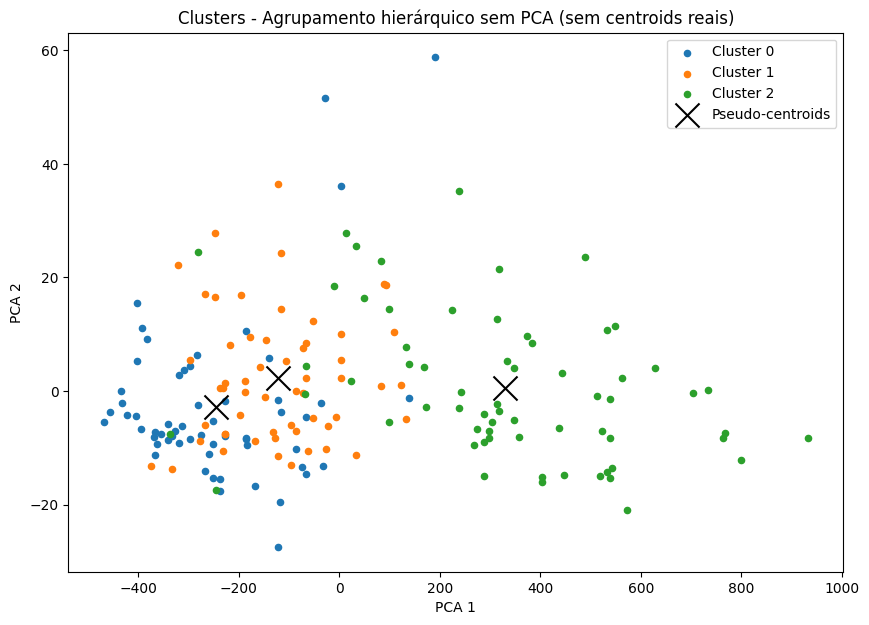

In [27]:
# PCA PARA VISUALIZAÇÃO
pca_vis = PCA(n_components = 2)
dados_2d = pca_vis.fit_transform(vinhos)
# CRIA UMA LISTA 
centroids = []
# RODA UM FOR PARA CADA VALOR UNICO DENTRO DE CLASSIFICACAO 3 E ADICIONAR A LISTA 'CENTROIDS' A MÉDIA ONDE CLASSIFICACAO3 TER O VALOR IGUALA  GRUPO
for grupo in np.unique(classificacao3):
    centroids.append(dados_2d[classificacao3 == grupo].mean(axis = 0))
# CONVERTE DE LISTA PARA NUMPY ARRAY
centroids = np.array(centroids)

# PLOTAGEM
plt.figure(figsize = (10,7))
for grupo in np.unique(classificacao3):
    plt.scatter(
        dados_2d[classificacao3 == grupo, 0],
        dados_2d[classificacao3 == grupo, 1],
        s = 20,
        label = f'Cluster {grupo}'
    )
plt.scatter(
    centroids[:,0], centroids[:, 1], s = 300, marker = 'x', c = 'black', label = 'Pseudo-centroids'
)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters - Agrupamento hierárquico sem PCA (com centroids geométricos)')
plt.legend()
plt.show()

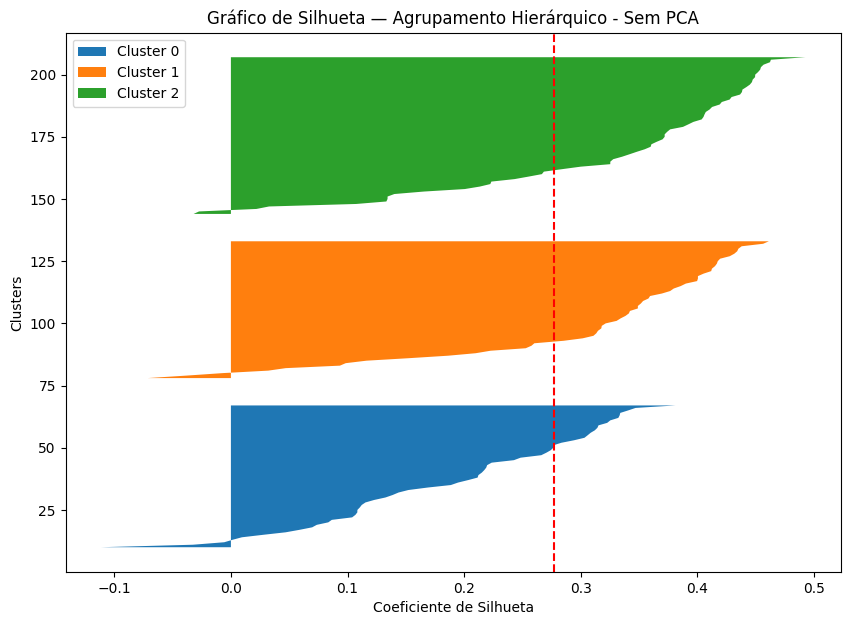

In [37]:
# PEGA O ARRAY CLASSIFICANDO CADA VALOR PARA UM DOS CLUSTERS
labels = classificacao3
# OBTEÉM O SCORE DA SILHOUETTA E O VALOR INDIVIDUAL DE CADA REGISTROS
silhouette_vals = silhouette_samples(dados_transformados, labels)
silhouette_avg = silhouette_score(dados_transformados, labels)
# PLOTA UM GRÁFICO PARA CADA REGISTRO COM SEU VALOR DE SILHUETA
plt.figure(figsize=(10, 7))
y_lower = 10

for i in np.unique(labels):
    cluster_vals = silhouette_vals[labels == i]
    cluster_vals.sort()
    size_cluster = cluster_vals.shape[0]
    y_upper = y_lower + size_cluster

    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_vals,
        label=f'Cluster {i}'
    )
    y_lower = y_upper + 10
# CONFIGURAÇÕES EXTRAS DO GRÁFICO
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.title("Gráfico de Silhueta — Agrupamento Hierárquico - Sem PCA")
plt.xlabel("Coeficiente de Silhueta")
plt.ylabel("Clusters")
plt.legend()
plt.show()

In [38]:
#CALCULA A SILHUETA INDIVIDUAL
sil_values = silhouette_samples(dados_padronizados, classificacao3)
# O VALOR INICAL E FINAL DA SILHUETA DE CADA CLUSTER
for k in np.unique(classificacao3):
    vals = sil_values[classificacao3 == k]
    print(f"Cluster {k}: {vals.min():.3f} → {vals.max():.3f}")

Cluster 0: -0.112 → 0.381
Cluster 1: -0.071 → 0.461
Cluster 2: -0.032 → 0.493


#### **INSERÇÃO DOS LABELS NO DATASET ORIGINAL**
Nesta etapa, Transformei os agrupamentos criados pelo k-means no dataset original. Mostrando a qual grupo cada registro pertence.
- Criação do dataframe 'agrupamento'
- Criando um novo dataset com a c

In [39]:
#cria o agrupamento criado pelo algortimo
agrupamento3 = pd.DataFrame(classificacao3, columns= ['Agrupamento'])
agrupamento3
#concatena o agrupamento junto do dataset copiado do original
vinhos_hier = pd.concat([vinhos, agrupamento3], axis = 1)
vinhos_hier

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Agrupamento
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,2
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,2
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,2
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,2
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,1
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,1
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,1
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,1


#### **CONCLUSÃO FINAL DO AGRUPAMENTO HIERÁRQUICO (SEM PCA)**
Após aplicar o algoritmo de agrupamento hierárquico (sem PCA), observou-se que a qualidade geral da clusterização foi inferior quando comparada aos resultados obtidos com o K-Means. As métricas confirmam essa piora:

- Silhouette Score (0.2774): indicou uma separação fraca entre os grupos, sugerindo que os clusters estão próximos e parcialmente sobrepostos.

- Calinski-Harabasz (67.65): apresentou queda em relação ao K-Means, indicando menor coesão interna e fraca separação entre os clusters.

- Davies-Bouldin (1.419): foi maior, apontando clusters menos compactos e com distâncias pouco estruturadas.

A análise do gráfico de silhueta reforça esse cenário:

- Cluster 0: teve o pior desempenho, iniciando em valor negativo (-0.112), com faixa estreita e grande concentração de valores abaixo da média global — forte evidência de má formação e baixa separação.

- Cluster 1: apresentou leve melhora em relação ao cluster 0, mas ainda começou abaixo de zero (-0.071), teve poucos valores acima da média global e exibiu grande variância nesses valores, indicando instabilidade.

- Cluster 2: apesar de também iniciar abaixo de zero (-0.032), apresentou a melhor diversidade de valores acima da média global e maior preenchimento, sendo o mais consistente entre os três.

De forma geral, o agrupamento hierárquico apresentou desempenho significativamente inferior ao K-Means. As métricas pioraram, todos os clusters iniciaram com coeficientes negativos e a variabilidade interna foi mais fraca, indicando baixa distinção entre os grupos e menor qualidade estrutural na formação dos clusters.


## **AGRUPAMENTO HIERARQUICO - COM PCA**

Nesta seção apliquei o agrupamento hiérarquico com PCA, como indicado na seção de definição de clusters, o agrupamento hiérarquico apontou um valor muito bom para uso de 3 clusters, como indica o dendograma e o teste de shilhouette.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

In [13]:
pipe_hierarquico_pca

,steps,"[('scalonar', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'


#### **CENTRÓIDES DOS GRUPOS (CLUSTERS CENTERS)**
- Previsão dos valores
- Agrupamento de cada variavel e quantidade por grupo

In [46]:
#treinando e realizando as previsoes do com os dados de vinho
classificacao4 = pipe_hierarquico_pca.fit_predict(vinhos)

In [47]:
#captando os valores
valores, contagens = np.unique(classificacao4, return_counts = True)
#grupos criados
print(classificacao4)
#Grupos criados
print(valores)
#quantidada em cada grupo
print(contagens)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 1 2 2 1 2 2 1 2 1 2 1
 1 2 2 2 1 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 1 1
 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 2]
[48 71 59]


#### **AVALIANDO MÉTRICAS**
Nesta etapa, utilizo as métricas de Silhouette, Calinski e Davies. Cada métrica tem sua importação na definição do modelo que melhor agrupa e é consistente na sua função:

Silhouette, mede o quão bem os pontos estão dentro do seu cluster e loge dos outros clusters, (0 a 1, quanto maior melhor).
- 0.70 - 1.0: Excelent clusterização
- 0.50 - 0.69: Boa
- 0.30 - 0.49: Regular
- 0.00 - 0.29: Fraca (clusters se sobrepõem)
- Negativo: Horrível (dados nos clusters errados)


Calinski-Harabasz, mede a separação entre clusters versos a compactação dentro deles, (Valores Infinitos: quanto maior melhor)
- Valores altos = clusters bem definidos
- Não tem faixa exata, é feito a comparação entre os modelos testados.


      
 Davies-Bouldin, mede o quão proximos os pontos dos clusters estão do seu centróide (quanto menor, mais compacto) e mede a distância entre os dentróides de dois clusters (quanto maior, mais separados)
- Baixo DBI: Clusters compactos e bem separados
- Alto DBI: Clusters espalhados e se confundindo
-  0.2 - 0.6: Excelente
-  0.6 - 1.2 Razóavel
-  maior ou igual a 1.5 Ruim (Clusters muito próximo ou mal definidos) 

In [48]:
# ESCALONA NOVAMENTE OS CENTROIDS
dados_transformados = pipe_hierarquico_pca.named_steps['scalonar'].transform(vinhos) 

# MÉTRICAS UTILIZADAS PARA AVALIAÇÃO DO AGRUPAMENTO
sil = silhouette_score(dados_transformados, classificacao4)
calinski = calinski_harabasz_score(dados_transformados, classificacao4)
davies = davies_bouldin_score(dados_transformados, classificacao4)

# RESULTADO PARA AS MÉTRICAS
print(f'Silhouette Score: {sil:.4}')
print(f'Calinski Score: {calinski:.4}')
print(f'Davies-Bouldin: {davies:.4}')

Silhouette Score: 0.2729
Calinski Score: 69.15
Davies-Bouldin: 1.412


#### **VISUALIZAÇÃO DOS RESULTADOS AGRUPAMENTO HIERÁRQUICO (SEM PCA)**
Nesta etapa, plotei alguns gráficos para ajudar na visualização e julgamento de cada clusters criado pelo agrupamento hierárquico (Com PCA)
- Scatterplot, apliquei a PCA somente nos dados para que fosse possivel realizar a visualização das variaveis e criei centroids geométricos, pois o agrupamento hierárquico não utiliza de centroids na sua equação, e sim distância, para agrupar.
- Gráfico de Silhueta, para avaliar cada cluster individualmente, mais coeso, está ácima da média global
- Valores reais do inicio e fim da silhueta média do cluster

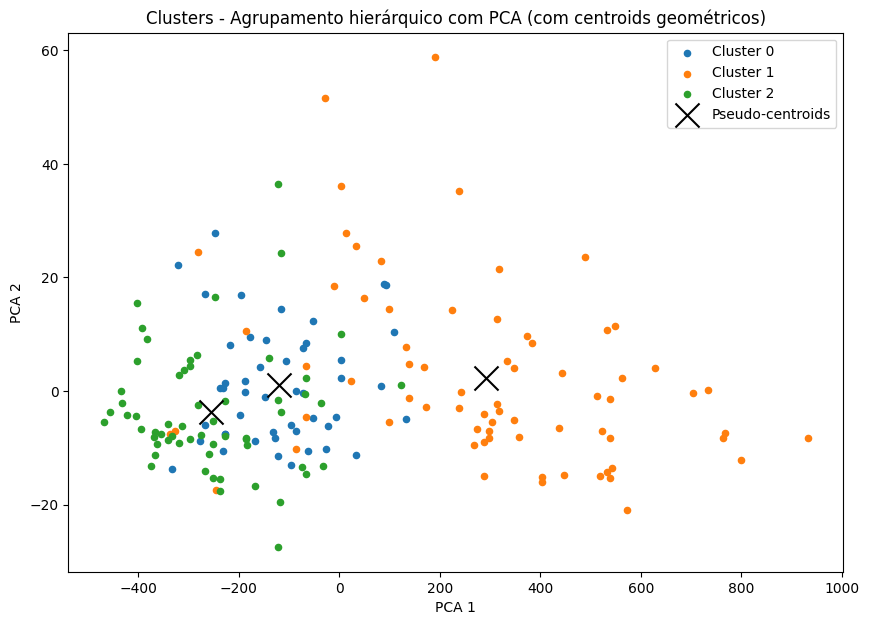

In [54]:
# PCA PARA VISUALIZAÇÃO
pca_vis = PCA(n_components = 2)
dados_2d = pca_vis.fit_transform(vinhos)
# CRIA UMA LISTA 
centroids = []
# RODA UM FOR PARA CADA VALOR UNICO DENTRO DE CLASSIFICACAO 3 E ADICIONAR A LISTA 'CENTROIDS' A MÉDIA ONDE CLASSIFICACAO3 TER O VALOR IGUALA  GRUPO
for grupo in np.unique(classificacao4):
    centroids.append(dados_2d[classificacao4 == grupo].mean(axis = 0))
# CONVERTE DE LISTA PARA NUMPY ARRAY
centroids = np.array(centroids)

# PLOTAGEM
plt.figure(figsize = (10,7))
for grupo in np.unique(classificacao4):
    plt.scatter(
        dados_2d[classificacao4 == grupo, 0],
        dados_2d[classificacao4 == grupo, 1],
        s = 20,
        label = f'Cluster {grupo}'
    )
plt.scatter(
    centroids[:,0], centroids[:, 1], s = 300, marker = 'x', c = 'black', label = 'Pseudo-centroids'
)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters - Agrupamento hierárquico com PCA (com centroids geométricos)')
plt.legend()
plt.show()

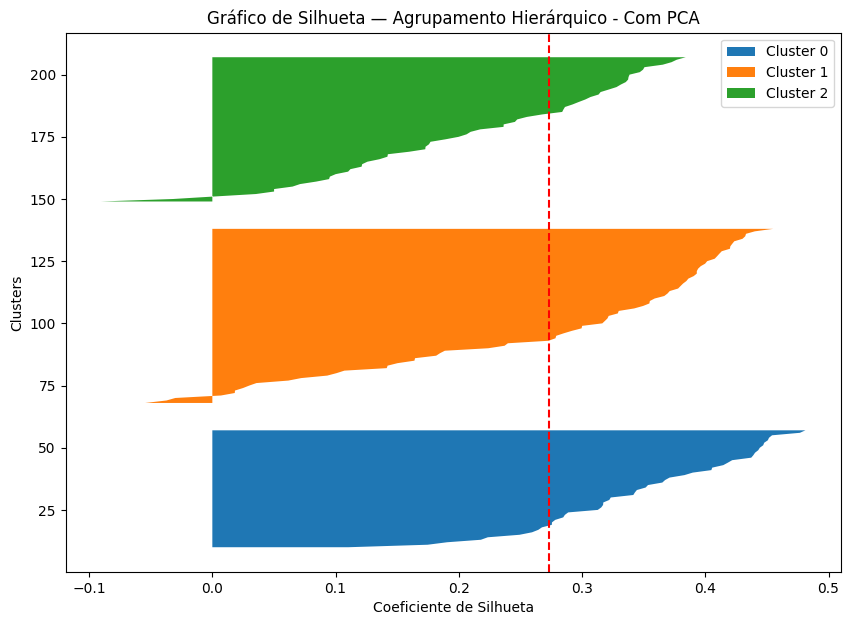

In [53]:
# PEGA O ARRAY CLASSIFICANDO CADA VALOR PARA UM DOS CLUSTERS
labels = classificacao4
# OBTEÉM O SCORE DA SILHOUETTA E O VALOR INDIVIDUAL DE CADA REGISTROS
silhouette_vals = silhouette_samples(dados_transformados, labels)
silhouette_avg = silhouette_score(dados_transformados, labels)
# PLOTA UM GRÁFICO PARA CADA REGISTRO COM SEU VALOR DE SILHUETA
plt.figure(figsize=(10, 7))
y_lower = 10

for i in np.unique(labels):
    cluster_vals = silhouette_vals[labels == i]
    cluster_vals.sort()
    size_cluster = cluster_vals.shape[0]
    y_upper = y_lower + size_cluster

    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_vals,
        label=f'Cluster {i}'
    )
    y_lower = y_upper + 10
# CONFIGURAÇÕES EXTRAS DO GRÁFICO
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.title("Gráfico de Silhueta — Agrupamento Hierárquico - Com PCA")
plt.xlabel("Coeficiente de Silhueta")
plt.ylabel("Clusters")
plt.legend()
plt.show()

In [52]:
#CALCULA A SILHUETA INDIVIDUAL
sil_values = silhouette_samples(dados_padronizados, classificacao4)
# O VALOR INICAL E FINAL DA SILHUETA DE CADA CLUSTER
for k in np.unique(classificacao4):
    vals = sil_values[classificacao4 == k]
    print(f"Cluster {k}: {vals.min():.3f} → {vals.max():.3f}")

Cluster 0: 0.110 → 0.481
Cluster 1: -0.054 → 0.455
Cluster 2: -0.090 → 0.384


#### **INSERÇÃO DOS LABELS NO DATASET ORIGINAL**
Nesta etapa, Transformei os agrupamentos criados pelo agrupamento hierárquico com PCA no dataset original. Mostrando a qual grupo cada registro pertence.
- Criação do dataframe 'agrupamento4'
- Criando um novo dataset com a concatenação dos agrupamentos e registros reais.
- Exibição da tabela final.

In [55]:
#cria o agrupamento criado pelo algortimo
agrupamento4 = pd.DataFrame(classificacao4, columns= ['Agrupamento'])
agrupamento4
#concatena o agrupamento junto do dataset copiado do original
vinhos_hier_PCA = pd.concat([vinhos_copia, agrupamento4], axis = 1)
vinhos_hier_PCA

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Agrupamento
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,0
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,0
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,0
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,0


In [ ]:
Silhouette Score: 0.2729
Calinski Score: 69.15
Davies-Bouldin: 1.412
Silhouette Score: 0.2774
Calinski Score: 67.65
Davies-Bouldin: 1.419

#### **CONCLUSÃO FINAL DO AGRUPAMENTO HIERÁRQUICO (COM PCA)**

Após aplicar o algoritmo de Agrupamento Hierárquico com PCA, observou-se que o desempenho geral piorou em relação à versão sem PCA. O Silhouette Score caiu para 0.2729, indicando maior sobreposição entre os clusters e menor separação estrutural. O índice de Calinski-Harabasz (69.15) apresentou leve melhora, sugerindo uma separação um pouco mais nítida entre os grupos. Já o Davies-Bouldin (1.412) manteve um valor elevado, mostrando que os clusters continuam pouco compactos e próximos entre si.

A análise do gráfico de silhueta confirmou esse comportamento:

- Cluster 0: apresentou o melhor desempenho na versão com PCA. Iniciou com o maior valor (0.110) e mostrou boa variabilidade antes da média global, sendo o cluster mais consistente.

- Cluster 1: foi o segundo melhor. Embora tenha começado com valor negativo (–0.054), mostrou a maior “barriga” após a média global. Entretanto, o início negativo indica que parte dos pontos está mal alocada, prejudicando a separação.

- Cluster 2: apresentou o pior desempenho. Além de iniciar com valor negativo, teve perda significativa de variância ao longo da barriga, indicando baixa qualidade e má definição do grupo.

No geral, o agrupamento hierárquico com PCA teve desempenho inferior ao modelo sem PCA e também ficou abaixo das versões com K-Means. A redução da dimensionalidade não ajudou a melhorar a estrutura dos clusters e, na prática, deixou a formação dos grupos mais fraca e menos coerente.

## **DBSCAN - SEM PCA**

O algoritmo DBSCAN (Density-Based Spatial Clustering of Applications with Noise) é um método de clusterização baseado em densidade.
Diferente de K-Means e Agrupamento Hierárquico, ele:

- não exige escolher o número de clusters;

- identifica automaticamente regiões densas;

- detecta ruído e outliers (label = –1);

- forma clusters de formatos arbitrários (não apenas esféricos).

Os dois hiperparâmetros centrais são:

- eps → raio máximo para considerar vizinhos;

- min_samples → quantidade mínima de pontos dentro do raio para formar um cluster.

Clusters muito fragmentados ou excesso de pontos em –1 indicam necessidade de ajustar o raio ou os vizinhos mínimos.


https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [159]:
pipe_DBSCAN

,steps,"[('scalonar', ...), ('DBS', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,eps,2.722222
,min_samples,14
,metric,'euclidean'
,metric_params,None


#### **Ajuste do Modelo e Captura de Resultados**
- Previsão dos valores
- Agrupamento de cada variavel e quantidade por grupo

In [156]:
classificacao5 = pipe_DBSCAN.fit_predict(vinhos)

In [157]:
#captando os valores
valores, contagens = np.unique(classificacao5, return_counts = True)
#grupos criados
print(classificacao5)
#Grupos criados
print(valores)
#quantidada em cada grupo
print(contagens)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 -1 -1  1  0  0  0  0  0  0 -1 -1  0 -1
  0 -1 -1  0  0  0 -1 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0 -1
 -1  0  0 -1  0  0  0  0  0  0  0  0  0 -1 -1  0 -1  0  0 -1  0  0  1  0
  0 -1 -1 -1 -1  0  0 -1  0  0 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1]
[-1  0  1]
[ 27 105  46]


#### **AVALIANDO MÉTRICAS**
Nesta etapa, utilizo as métricas de Silhouette e Davies. Para o DBSCAN, as métricas são avaliadas de uma maneira diferente. Como o algortimo gera ruídos, é precisa e excluir esse grupo do silhouette score, pois ele não reage a ruídos.

Silhouette, mede o quão bem os pontos estão dentro do seu cluster e loge dos outros clusters, para o DBSCAN, os valores estão um pouco menores. 
- maior ou igual 0.25 - 0.30: clusters bem formados, densidades distintas, poucos ruídos
- < 0.15: clusters fracos, desidades parecidos, zonas de transição, muito ruídos
- negativo: DBSCAN provavelmente segmentou mal, eps inadequado, clusters sobrepostos


Davies-Bouldin, mede o quão proximos os pontos dos clusters estão do seu centróide (quanto menor, mais compacto) e mede a distância entre os dentróides de dois clusters (quanto maior, mais separados)
- Baixo DBI: Clusters compactos e bem separados
- Alto DBI: Clusters espalhados e se confundindo
-  0.2 - 0.6: Excelente
-  0.6 - 1.2 Razóavel
-  maior ou igual a 1.5 Ruim (Clusters muito próximo ou mal definidos) 

In [173]:
# ESCOLNA O DATASET
dados_transformados = pipe_DBSCAN.named_steps['scalonar'].transform(vinhos)

#CRIA UM ARRAY SOMENTE COM OS DADOS QUE SÃO DIFERENTES DO AGRUPAMENTO DOS RUÍDOS
mask = classificacao5 != -1

# APLICA O SILHOUETTE_SCORE, UTILIZANDO OS DADOS E LABELS QUE NÃO SÃO RUÍDOS
sil = silhouette_score(dados_transformados[mask], classificacao5[mask])
# APLICAÇÃO DO DAVIES
davies = davies_bouldin_score(dados_transformados, classificacao5)

# EXIBE OS RESULTADOS
print("Silhouette Score: {:.4%}".format(sil))
print(f"Davies-Bouldin: {davies:.4f}")

Silhouette Score: 31.1783%
Davies-Bouldin: 3.0555


#### **INSERÇÃO DOS LABELS NO DATASET ORIGINAL**
Nesta etapa, Transformei os agrupamentos criados pelo DBSCAN sem PCA no dataset original. Mostrando a qual grupo cada registro pertence.
- Criação do dataframe 'vinhos_DBSCAN'
- Criando um novo dataset com a concatenação dos agrupamentos e registros reais.
- Exibição da tabela final.

In [174]:
#cria o agrupamento criado pelo algortimo
agrupamento5 = pd.DataFrame(classificacao5, columns= ['Agrupamento'])
agrupamento5
#concatena o agrupamento junto do dataset copiado do original
vinhos_DBSCAN = pd.concat([vinhos, agrupamento5], axis = 1)
vinhos_DBSCAN

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Agrupamento
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,1
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,1
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,1
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,1


#### **CONCLUSÃO FINAL DO DBSAN (SEM PCA)**
Após aplicar o algortimo DBSCAN diretamente sobre as variáveis padronizadas, foi possível identificar grupos distintos no conjunto de dados.

As métricas indicaram uma qualidade moderada de clusterização, com destaque para:
- Silhouette Score, indicando uma separação excelente e baixos ruídos
- Davies-Bouldin, muito elevado, indica que há sobreposição.

O DNNSCAM encontrou apenas 2 clusters, com uma proporção muito boa de ruídos (~15%), as métricas indicam uma ótimos clusters, porém com uma sobreposição moderada, refletida no Silhouette score e Davies-Bouldin. Comparado ao k-means e ao hierárquico. O dbscan ofecere menos estruturação global, mas dectata regiões densas de forma mais fiel à distribuição real dos dados.



## **DBSCAN COM PCA**

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [ ]:
#predição e treino do modelo
classificacao6 = pipeline_vinho_DBSCAN_pca.fit_predict(vinhos_copia)

In [ ]:
#captando os valores
valores, contagens = np.unique(classificacao6, return_counts = True)
#grupos criados
print(classificacao6)
#Grupos criados
print(valores)
#quantidada em cada grupo
print(contagens)

[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0 -1  0  0  0 -1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0
  0  0 -1  0  0  0  0  0  0  0  0  1  1  1  0  0  1  0  0  1 -1  0  1  0
 -1  0  0  1  1  1  0  0 -1  0  1  2  0  1  1  1  1  1  1  1  1  1  1  0
 -1  1  0  1  1  1  0  1  1  1  1  1  1  0  0  1  1  1  1 -1  1  1 -1  1
  0  0  1 -1  0  1  0  1  1  1 -1  2  2  2  2  2  2  2  2  2  2  2  2  2
 -1  2  2  2  2  2  2  2 -1  2  2 -1  2  2 -1 -1  2 -1  2  2  2  2  2  2
  2  2 -1  2  2  2  2  2  2 -1]
[-1  0  1  2]
[21 75 42 40]


**Agrupamento**

In [ ]:
#cria o agrupamento criado pelo algortimo
agrupamento6 = pd.DataFrame(classificacao6, columns= ['Agrupamento'])
agrupamento6
#concatena o agrupamento junto do dataset copiado do original
vinhos_DBSCAN_PCA = pd.concat([vinhos_copia, agrupamento6], axis = 1)
vinhos_DBSCAN_PCA

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Agrupamento
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,-1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,2
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,2
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,2
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,2


## **MEANSHIFT COM TODOS OS ATRIBUTOS**

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.mean_shift.html

In [ ]:
classificacao7 = pipeline_vinho_meanshift.fit_predict(vinhos_copia)

In [ ]:
#captando os valores
valores, contagens = np.unique(classificacao7, return_counts = True)
#grupos criados
print(classificacao7)
#Grupos criados
print(valores)
#quantidada em cada grupo
print(contagens)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 2 1 0 0 3
 0 0 0 1 2 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 1 0 0 0 0 0 1 0 0 4 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 1 2 3 4]
[108  64   3   1   2]


In [ ]:
#cria o agrupamento criado pelo algortimo
agrupamento7 = pd.DataFrame(classificacao7, columns= ['Agrupamento'])
agrupamento7
#concatena o agrupamento junto do dataset copiado do original
vinhos_meanshift = pd.concat([vinhos_copia, agrupamento7], axis = 1)
vinhos_meanshift

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Agrupamento
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,1
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,1
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,1
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,1


## **MEANSHIFT COM PCA**

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.mean_shift.html

In [ ]:
#Resultados dos agrupamentos
classificacao8 = pipeline_vinho_meanshift_pca.fit_predict(vinhos_copia)

In [ ]:
#captando os valores
valores, contagens = np.unique(classificacao8, return_counts = True)
#grupos criados
print(classificacao8)
#Grupos criados
print(valores)
#quantidada em cada grupo
print(contagens)

[0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0 3 0 0 0 0 0 0 0 0 0
 0 3 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 3 1 3 3 1 1 3 1 3 1 0
 3 1 1 1 3 3 1 3 1 2 3 3 1 1 1 1 1 1 1 3 3 0 1 3 3 3 3 1 1 1 1 1 1 1 1 3 3
 1 1 1 1 1 1 1 1 1 3 0 1 1 3 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 1 2 3]
[56 46 49 27]


In [ ]:
#cria o agrupamento criado pelo algortimo
agrupamento8 = pd.DataFrame(classificacao8, columns= ['Agrupamento'])
agrupamento8
#concatena o agrupamento junto do dataset copiado do original
vinhos_meanshift_pca = pd.concat([vinhos_copia, agrupamento8], axis = 1)
vinhos_meanshift_pca

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Agrupamento
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,3
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,2
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,2
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,2
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,2
